Hotel Booking Cancellation Prediction

# Libraries

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, mean_squared_error, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import os
import plotly.express as px

In [ ]:
FFILE = './hotel_booking.csv'
if os.path.isfile(FFILE):
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable, removing it and downloading again")
        !rm FFILE
        !wget "https://raw.githubusercontent.com/cancianpiero/hotel_booking/main/hotel_bookings.csv"
else:
    print("Either the file is missing or not readable, download it")
    !wget "https://raw.githubusercontent.com/cancianpiero/hotel_booking/main/hotel_bookings.csv"

Either the file is missing or not readable, download it
--2023-06-17 18:59:57--  https://raw.githubusercontent.com/cancianpiero/hotel_booking/main/hotel_bookings.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16855599 (16M) [text/plain]
Saving to: ‘hotel_bookings.csv’

hotel_bookings.csv  100%[===================>]  16.07M  --.-KB/s    in 0.1s    

2023-06-17 18:59:57 (127 MB/s) - ‘hotel_bookings.csv’ saved [16855599/16855599]



# Data cleaning

In [ ]:
df = pd.read_csv("./hotel_bookings.csv")
df.shape
#df.head()

(119390, 32)

In [ ]:
#df.info()

In [ ]:
#df.describe()

In [ ]:
#Getting an insight of all the unique values of each column of the dataset:
#pd.Series({col:df[col].unique() for col in df})

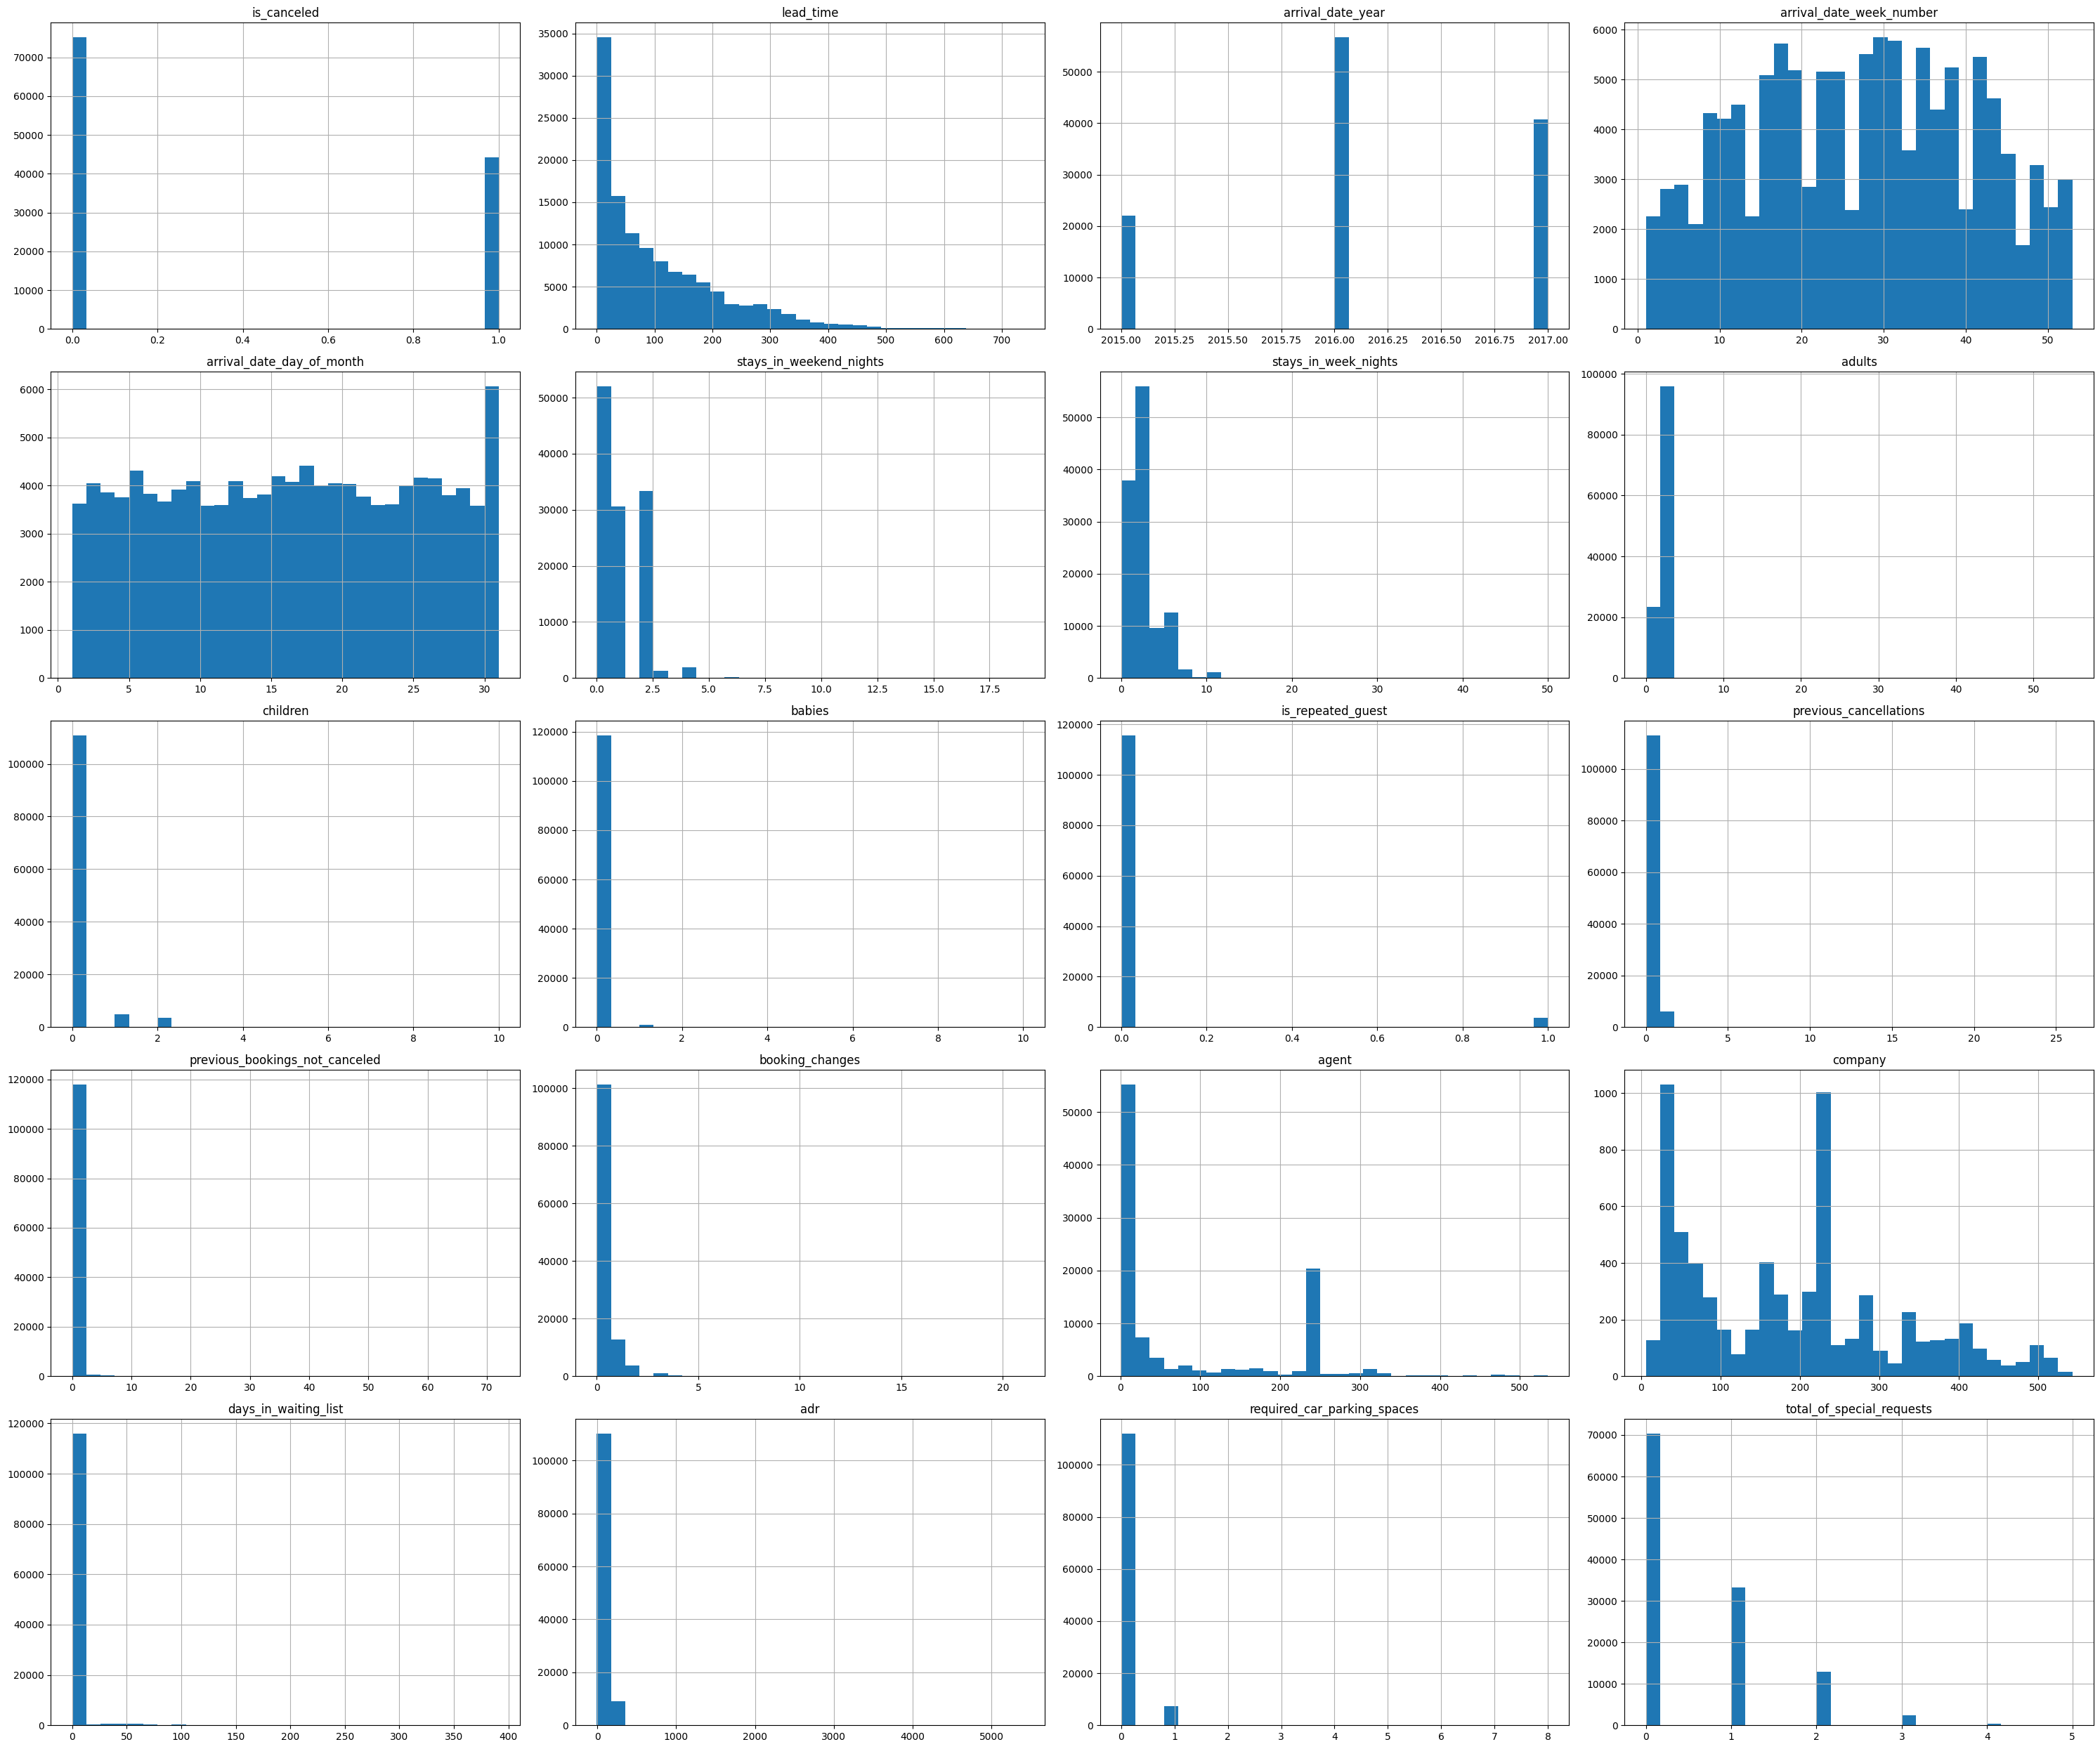

In [ ]:
# a histogram plot for each numerical attribute
df.hist(bins=30, figsize=(30,25))
plt.tight_layout()
plt.show()

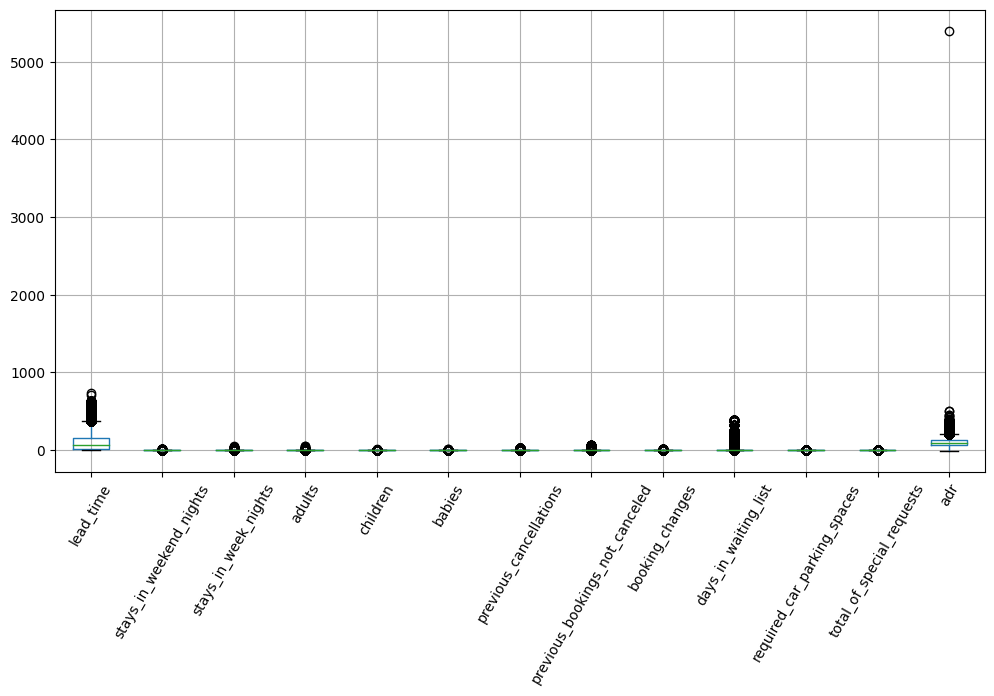

In [ ]:
cols = ['lead_time', 'stays_in_weekend_nights','stays_in_week_nights', 'adults', 'children',
        'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes',
        'days_in_waiting_list', 'required_car_parking_spaces','total_of_special_requests','adr']

df[cols].boxplot(rot=60, figsize=(12,6));

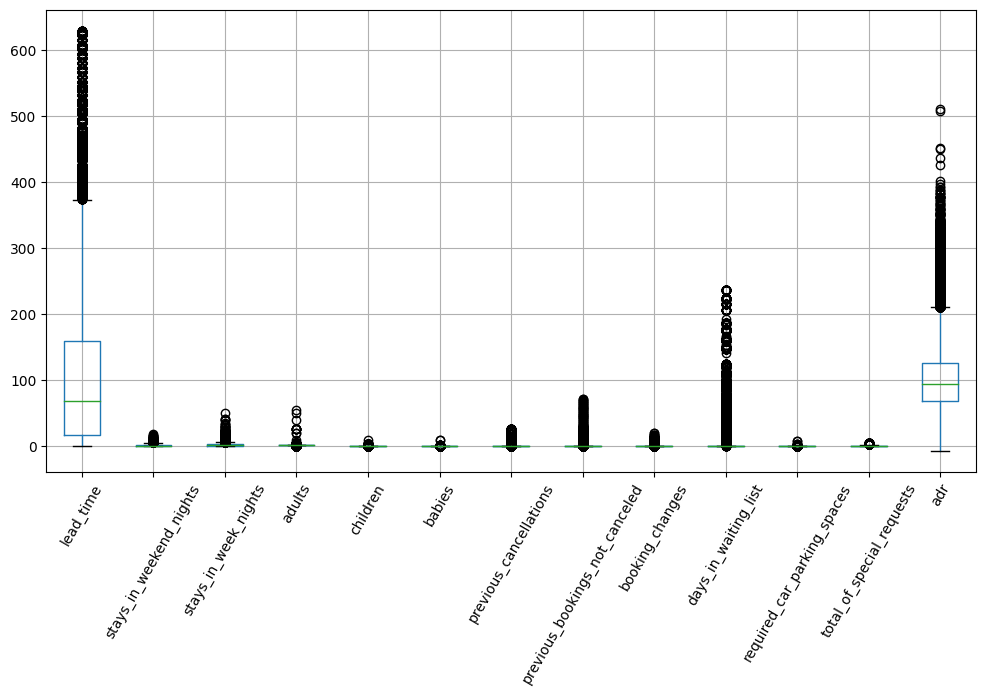

In [ ]:
#remove outliers
df = df[df['lead_time'] < 700]
df = df[df['days_in_waiting_list'] < 250]
df = df[df['adr'] < 1000]

df[cols].boxplot(rot=60, figsize=(12,6))
plt.show()

In [ ]:
# checking for null values
#df.isnull().sum().sort_values(ascending = False)

In [ ]:
# checking if the dataset has any duplicated rows
sum(df.duplicated())

31930

In [ ]:
# dropping the duplicate rows
df.drop_duplicates(inplace=True)
df.shape

(87372, 32)

In [ ]:
#Since these column has mostly "Other" as value it is not informative and we'd better get rid of it
df = df.drop(['agent', 'company'], axis = 1)

In [ ]:
df.shape

(87372, 30)

In [ ]:
#as there are only 4 cells with missing children data let's replace it by 0; and country column by "Unknown"
df["children"].fillna(0, inplace = True) #inplace=True argument to modify the original DataFrame rather than creating a new copy
df["country"].fillna("Unknown", inplace = True)

In [ ]:
# checking where there is no guests
filter_1 = (df['children']==0) & (df['adults']==0) & (df['babies']==0)
df.drop(df[filter_1].index, inplace = True)

In [ ]:
# checking where there is no booking days
filter_2 = (df['stays_in_weekend_nights']==0) & (df['stays_in_week_nights']==0)
df.drop(df[filter_2].index, inplace = True)

In [ ]:
# checking where there is no adults
filter_3 = (df['adults']==0)
df.drop(df[filter_3].index, inplace = True)

In [ ]:
# adding total_stays in the hotel as the sum of stays in weekend_nights and week_nights
df["total_stays"] = df["stays_in_week_nights"] + df["stays_in_weekend_nights"]

In [ ]:
# Undefined/SC both represent no meal package and can be combined
df['meal'].replace('Undefined', 'SC', inplace=True)

In [ ]:
# converting datatype of column 'children' from float to int.
df['children'] = df['children'].astype('int64')

In [ ]:
df.shape

(86397, 31)

In [ ]:
#df.info()

# Exploratory Data Analysis

In [ ]:
df_copy = df.copy()

In [ ]:
confirmed_bookings = df_copy[df_copy['is_canceled'] == 0]

In [ ]:
month = np.array(['January','February', 'March', 'April', 'May', 'June', 'July', 'August', 'September','October', 'November', 'December'])

## What is the percentage of booking in each hotel?

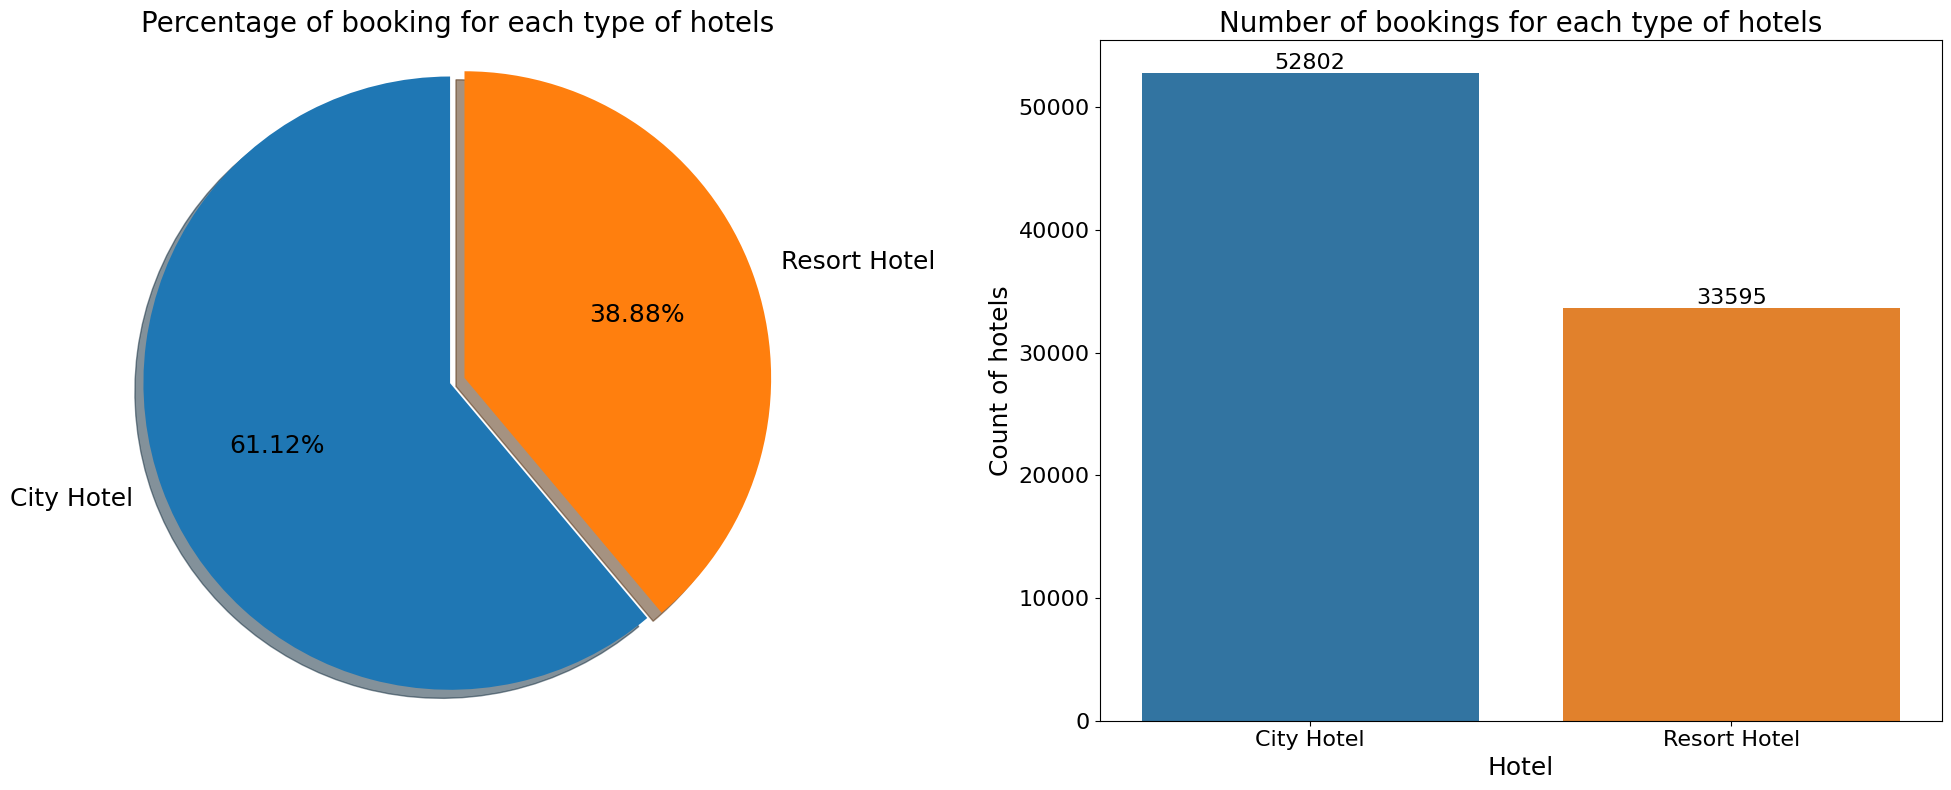

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# plotting the pie plot
data = np.array(df_copy['hotel'].value_counts().to_list())
labels = np.array(df_copy['hotel'].value_counts().index.to_list())
ax[0].pie(data, labels = labels, autopct='%0.2f%%', explode = [0,0.05], startangle=90, textprops={'fontsize': 18}, shadow = True)
ax[0].axis('equal')
ax[0].set_title('Percentage of booking for each type of hotels', fontsize=20)

# plotting the bar plot side by side
data_bar = df_copy['hotel'].value_counts().reset_index().rename(columns = {'index':'hotel', 'hotel':'count'})
ax[1] = sns.barplot(data=data_bar, y='count', x='hotel')
ax[1].set_title('Number of bookings for each type of hotels', fontsize=20)
ax[1].bar_label(ax[1].containers[0], fontsize=16)
ax[1].tick_params(axis="both", labelsize=16)
ax[1].set_xlabel('Hotel', fontsize=18)
ax[1].set_ylabel('Count of hotels', fontsize=18)

plt.tight_layout()
plt.show()

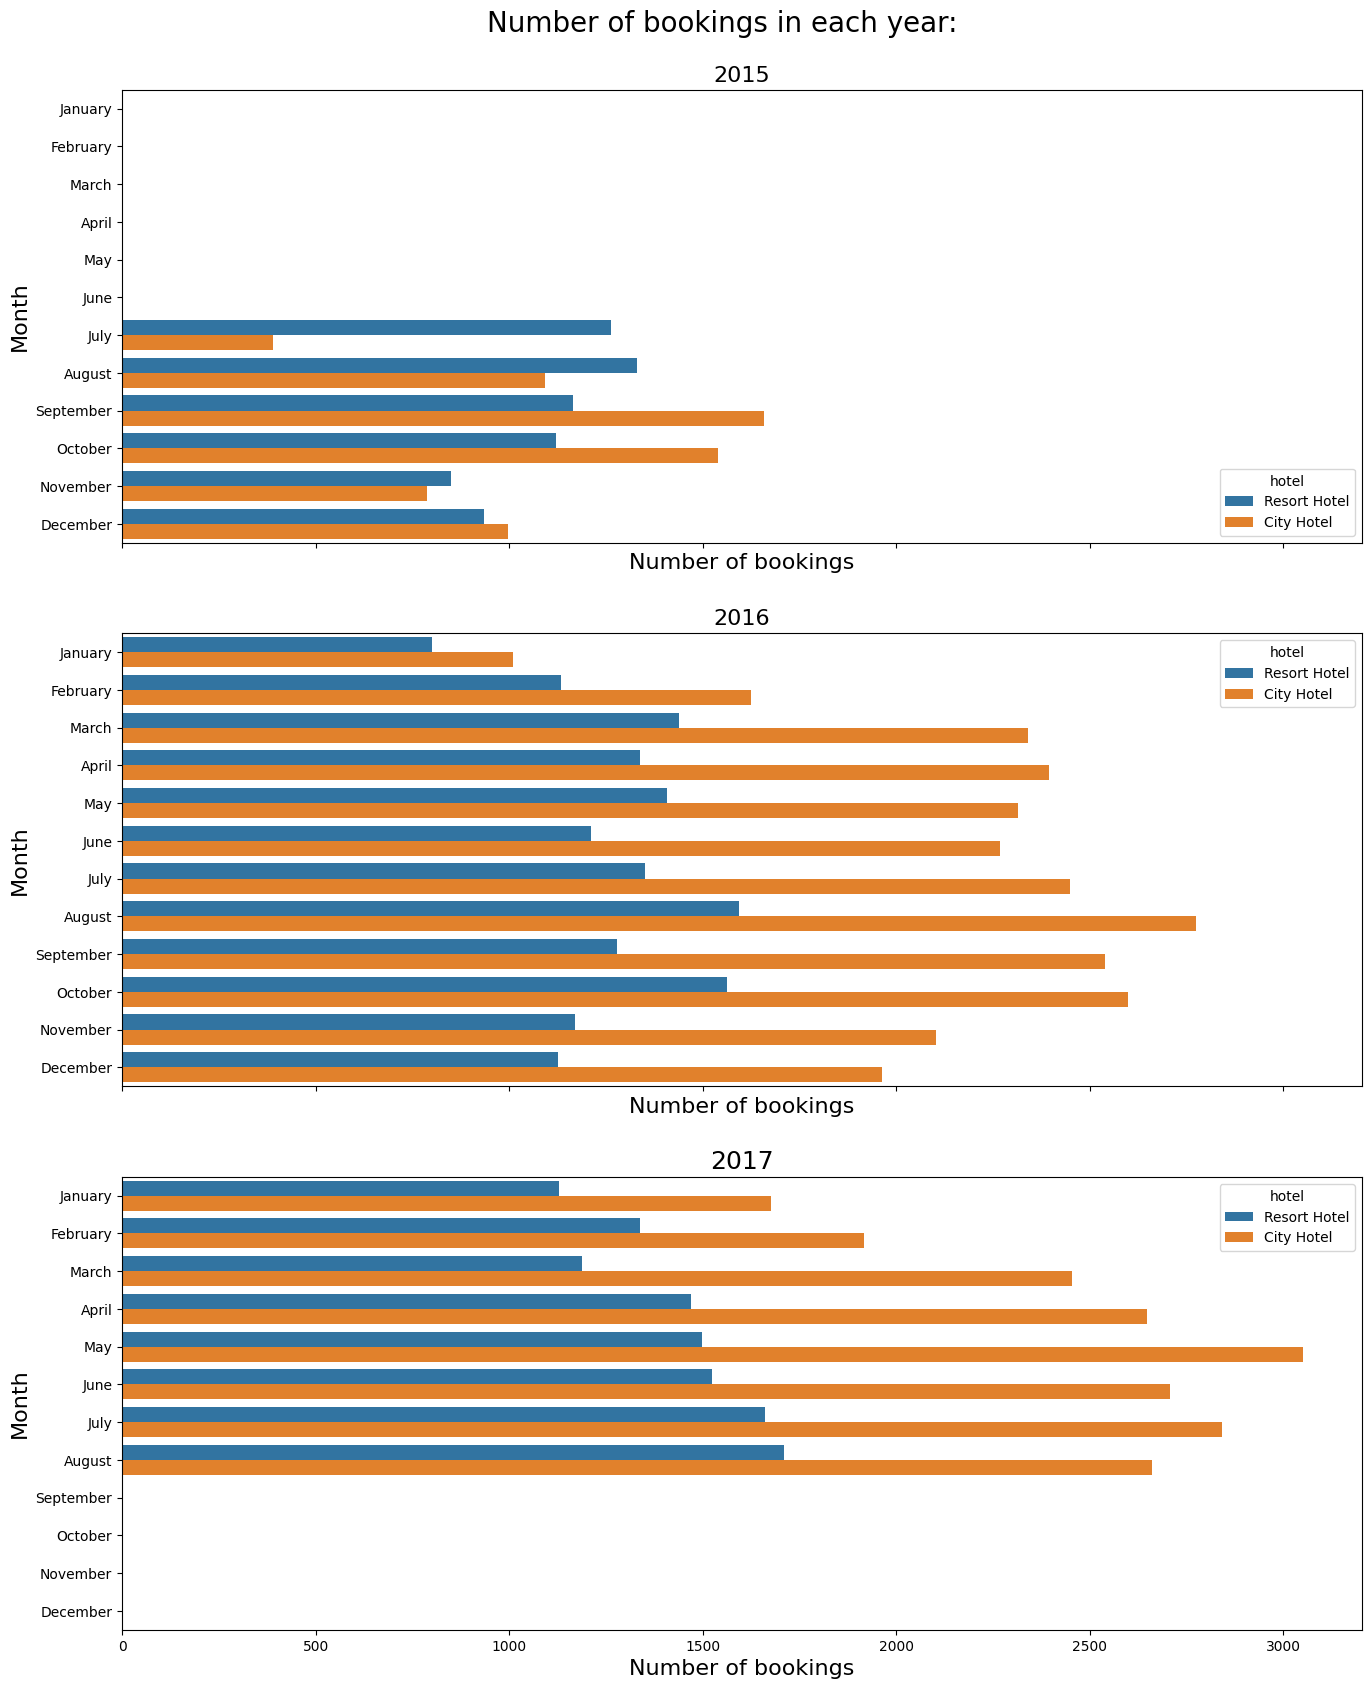

In [ ]:
data_2015=df_copy[df_copy["arrival_date_year"]==2015]
data_2016=df_copy[df_copy["arrival_date_year"]==2016]
data_2017=df_copy[df_copy["arrival_date_year"]==2017]

fig ,ax=plt.subplots(3,1, sharex=True, figsize=(16,20))
data = [data_2015, data_2016, data_2017]
years = [2015,2016,2017]

for i,year in enumerate(data):
    ax[i].set_title(f'{years[i]}', fontsize=16)
    sns.countplot(data=year, y="arrival_date_month", hue="hotel", order=month, ax=ax[i])
    ax[i].set_ylabel('Month', fontsize=16)
    ax[i].set_xlabel('Number of bookings', fontsize=16)
    plt.title(f'{years[i]}',fontsize=18)
plt.suptitle("Number of bookings in each year:", fontsize=20, y=.92)
plt.show()

## What is the most popular month for bookings at the city hotel and the resort hotel?

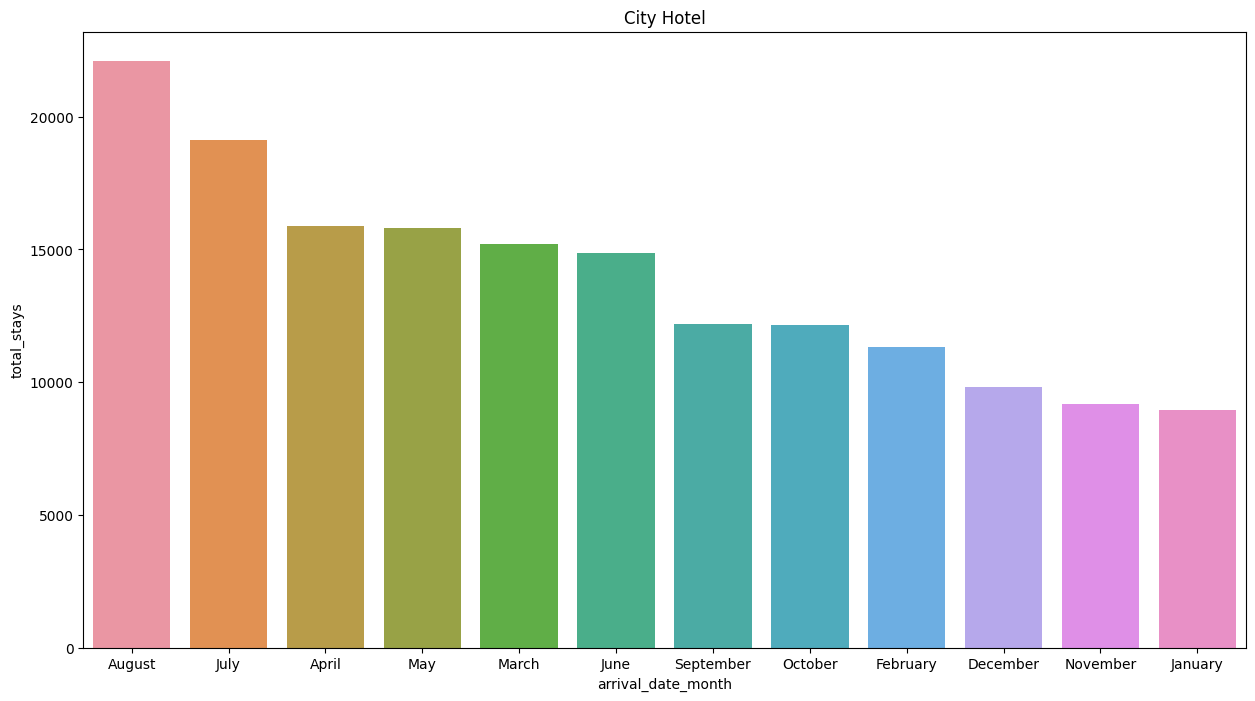

In [ ]:
df_resort_hotel = df_copy[df_copy['hotel'] == 'Resort Hotel']
df_city_hotel = df_copy[df_copy['hotel'] == 'City Hotel']
city_hotel = df_city_hotel.groupby('arrival_date_month', as_index=False)['total_stays'].sum().sort_values(by="total_stays", ascending = False)
resort_hotel = df_resort_hotel.groupby('arrival_date_month', as_index = False)['total_stays'].sum().sort_values(by = "total_stays", ascending = False)

plt.figure(figsize=(15,8))
sns.barplot(data=city_hotel, x='arrival_date_month', y='total_stays')
plt.title('City Hotel')
plt.show()

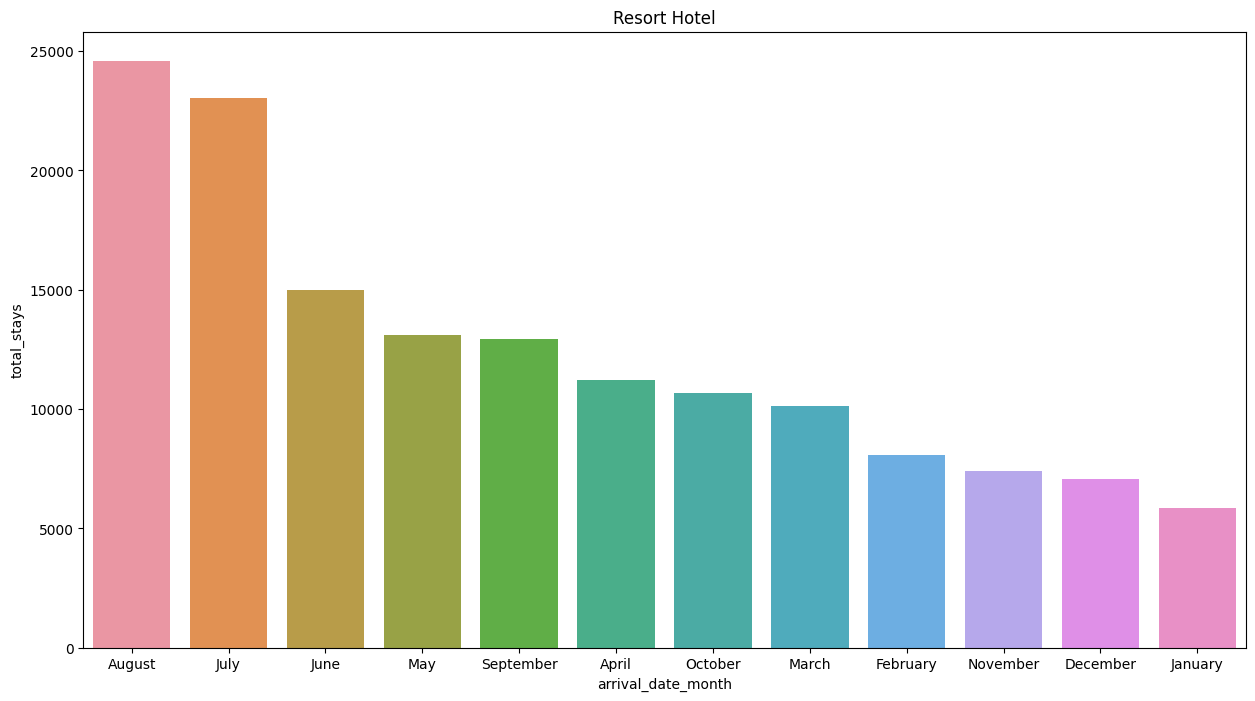

In [ ]:
plt.figure(figsize = (15,8))
sns.barplot(data = resort_hotel, x = 'arrival_date_month', y = 'total_stays')
plt.title('Resort Hotel')
plt.show()

In [ ]:
data = confirmed_bookings.groupby('arrival_date_month')['hotel'].value_counts().unstack().reindex(month).reset_index().rename_axis(None, axis=1)

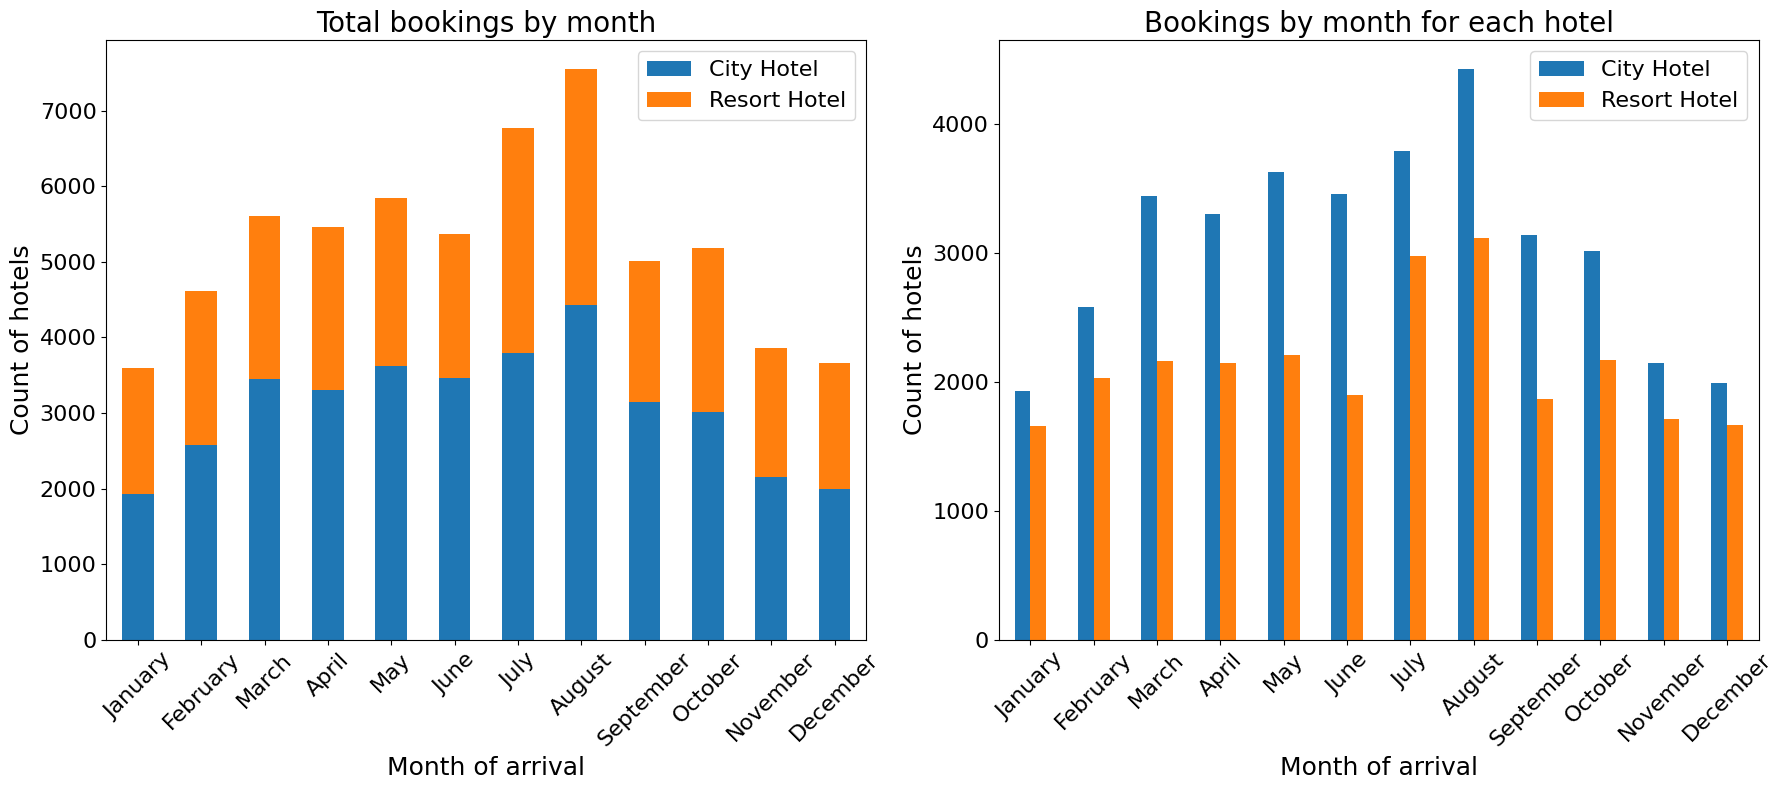

In [ ]:
# plotting the total bookings by month and bookings by month for each hotel
fig, ax = plt.subplots(1,2,figsize=(18,8))

data.plot(x='arrival_date_month', kind='bar', stacked=True, ax=ax[0], fontsize=16)
ax[0].set_title('Total bookings by month', fontsize=20)

data.plot(x='arrival_date_month', kind='bar', ax=ax[1], fontsize=16)
ax[1].set_title('Bookings by month for each hotel', fontsize=20)

for axis in ax.flatten():
    plt.sca(axis)
    plt.xlabel('Month of arrival', fontsize=18)
    plt.ylabel('Count of hotels', fontsize=18)
    plt.xticks(fontsize=16, rotation=45)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=16)

plt.tight_layout()
plt.show()

## How long people stay in each hotel?

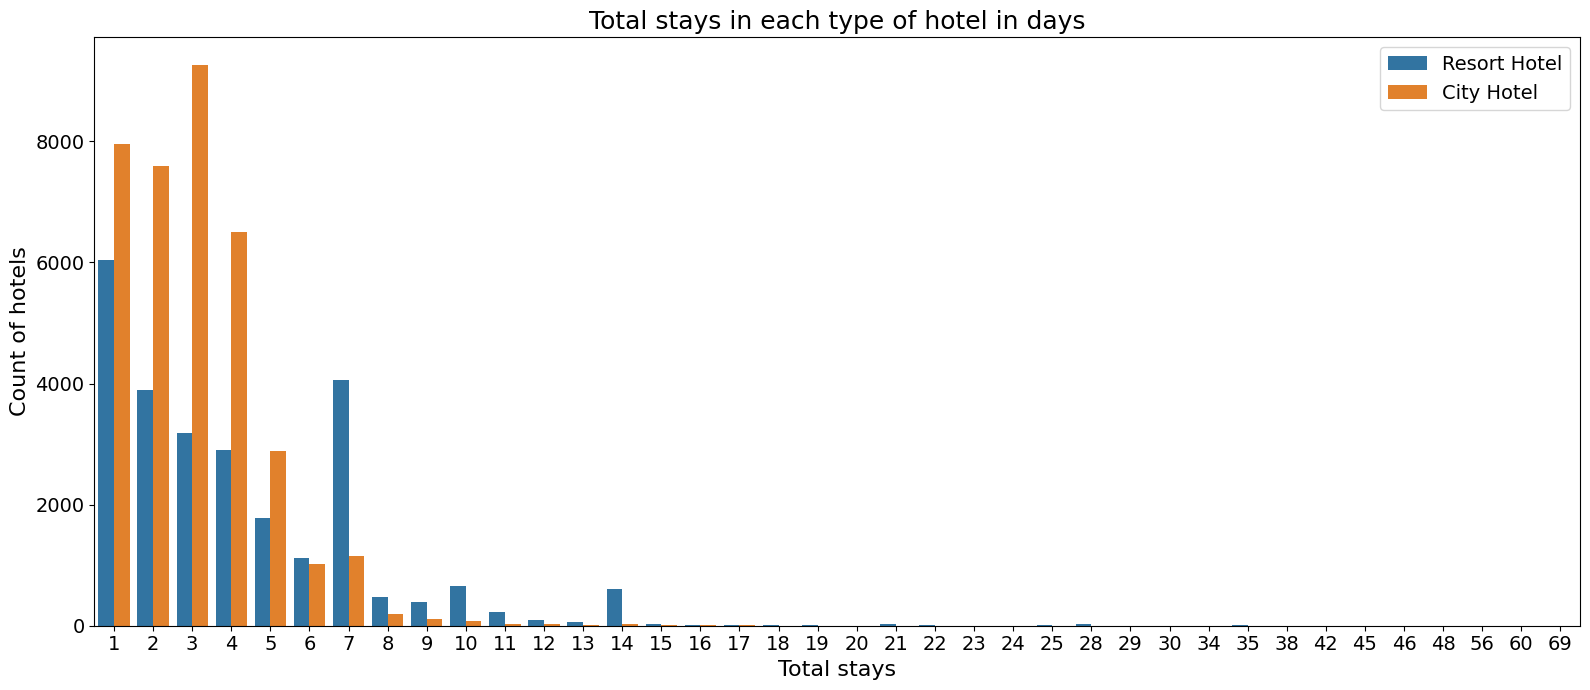

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))

fig1 = sns.countplot(x='total_stays', hue='hotel', data=confirmed_bookings, ax=ax)
fig1.set_title('Total stays in each type of hotel in days', fontsize=18)
fig1.set_ylabel('Count of hotels', fontsize=16)
fig1.legend(fontsize=14, loc=1)
plt.xlabel('Total stays', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()

## How does the price vary per night over the year?

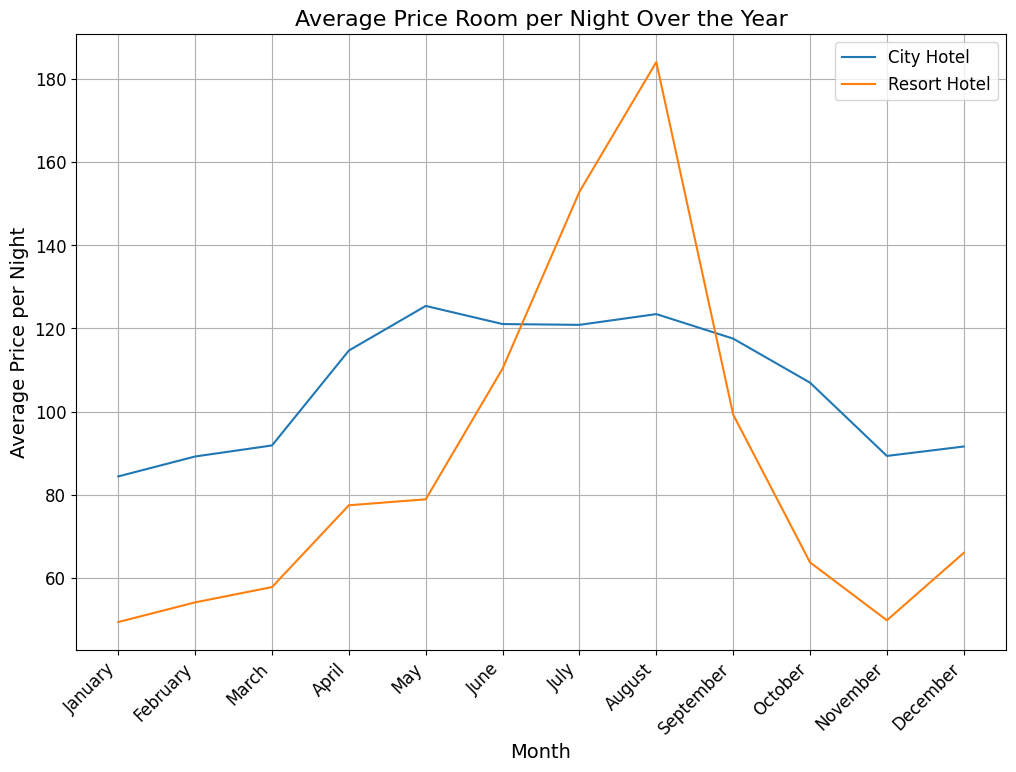

In [ ]:
df_city = df_copy[(df_copy['hotel'] == 'City Hotel') & (df_copy['is_canceled'] == 0)]
df_resort = df_copy[(df_copy['hotel'] == 'Resort Hotel') & (df_copy['is_canceled'] == 0)]

# calculate the average price per night for each month and hotel type
average_prices_city = df_city.groupby('arrival_date_month')['adr'].mean()
average_prices_resort = df_resort.groupby('arrival_date_month')['adr'].mean()

average_prices_city = average_prices_city.reindex(month)
average_prices_resort = average_prices_resort.reindex(month)

plt.figure(figsize=(12, 8))
sns.lineplot(data=average_prices_city, marker=None, label='City Hotel')
sns.lineplot(data=average_prices_resort, marker=None, label='Resort Hotel')
plt.title('Average Price Room per Night Over the Year', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Price per Night', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## From where do the most guests come?

In [ ]:
df_copy["country"].unique().size

178

In [ ]:
df_copy["country"].value_counts()

PRT    26809
GBR    10385
FRA     8778
ESP     7214
DEU     5372
       ...  
MMR        1
BFA        1
CYM        1
MLI        1
KHM        1
Name: country, Length: 178, dtype: int64

In [ ]:
# calculate countries by number of instances that appear in data
country_1 = (df_copy["country"].value_counts() <= 1).sum()
country_10 = (df_copy["country"].value_counts() <= 10).sum()
country_50 = (df_copy["country"].value_counts() <= 50).sum()
country_100 = (df_copy["country"].value_counts() <= 100).sum()
country_1000 = (df_copy["country"].value_counts() <= 1000).sum()

print("Number of countries with one or less instances:", country_1,
      "\nNumber of countries with 10 or less instances:", country_10,
      "\nNumber of countries with 50 or less instances:", country_50,
      "\nNumber of countries with 100 or less instances:", country_100,
      "\nNumber of countries with 1000 or less instances:", country_1000)

Number of countries with one or less instances: 32 
Number of countries with 10 or less instances: 86 
Number of countries with 50 or less instances: 127 
Number of countries with 100 or less instances: 142 
Number of countries with 1000 or less instances: 165


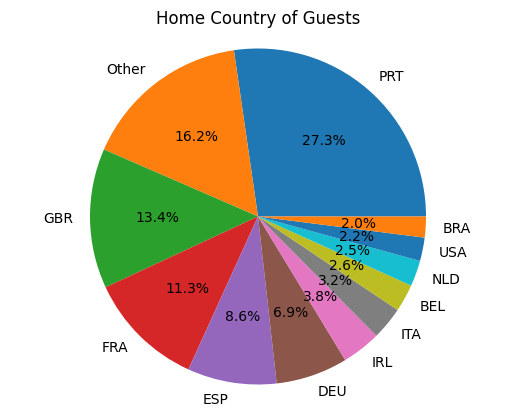

In [ ]:
state_counts = confirmed_bookings['country'].value_counts()

# Other = labels of states with less 2% of clients
labels = []
for state, count in state_counts.items():
    if count / len(confirmed_bookings) >= 0.02:
        labels.append(state)
    else:
        labels.append('Other')

# grouped counts for each label
grouped_counts = confirmed_bookings['country'].apply(lambda x: x if x in labels else 'Other').value_counts()

plt.pie(grouped_counts.values, labels=grouped_counts.index, autopct='%1.1f%%')
plt.title('Home Country of Guests')
plt.axis('equal')
plt.show()

## analysis of the variable 'is_canceled'

In [ ]:
df_copy['is_canceled'].value_counts()

0    62500
1    23897
Name: is_canceled, dtype: int64

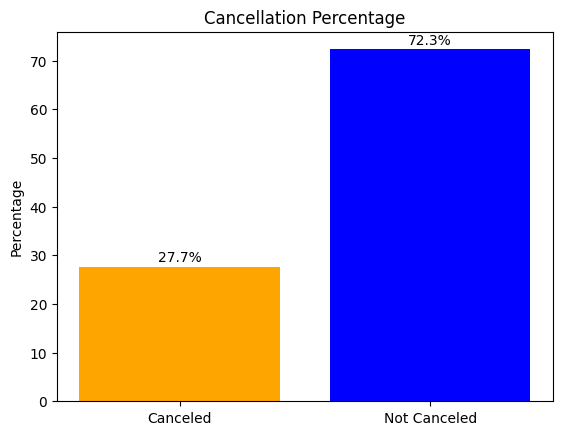

In [ ]:
cancel_counts = df_copy['is_canceled'].value_counts()

not_cancel_percent = cancel_counts[0] / cancel_counts.sum() * 100
cancel_percent = cancel_counts[1] / cancel_counts.sum() * 100

plt.bar(['Canceled', 'Not Canceled'], [cancel_percent, not_cancel_percent], color = ['orange', 'blue'])
plt.title('Cancellation Percentage')
plt.ylabel('Percentage')

for i, v in enumerate([cancel_percent, not_cancel_percent]):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')

plt.show()

In [ ]:
# looking at the correlation matrix of 'is_canceled'
corr_matrix = df_copy.corr()
corr_matrix['is_canceled'].sort_values(ascending=False)

<ipython-input-41-744a45b33331>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_copy.corr()


is_canceled                       1.000000
lead_time                         0.183382
adr                               0.127829
arrival_date_year                 0.086825
adults                            0.082505
total_stays                       0.081360
stays_in_week_nights              0.080127
children                          0.066463
stays_in_weekend_nights           0.057934
previous_cancellations            0.051409
arrival_date_day_of_month         0.005213
days_in_waiting_list              0.002911
arrival_date_week_number          0.002543
babies                           -0.020784
previous_bookings_not_canceled   -0.052417
is_repeated_guest                -0.084375
booking_changes                  -0.093560
total_of_special_requests        -0.122311
required_car_parking_spaces      -0.185800
Name: is_canceled, dtype: float64

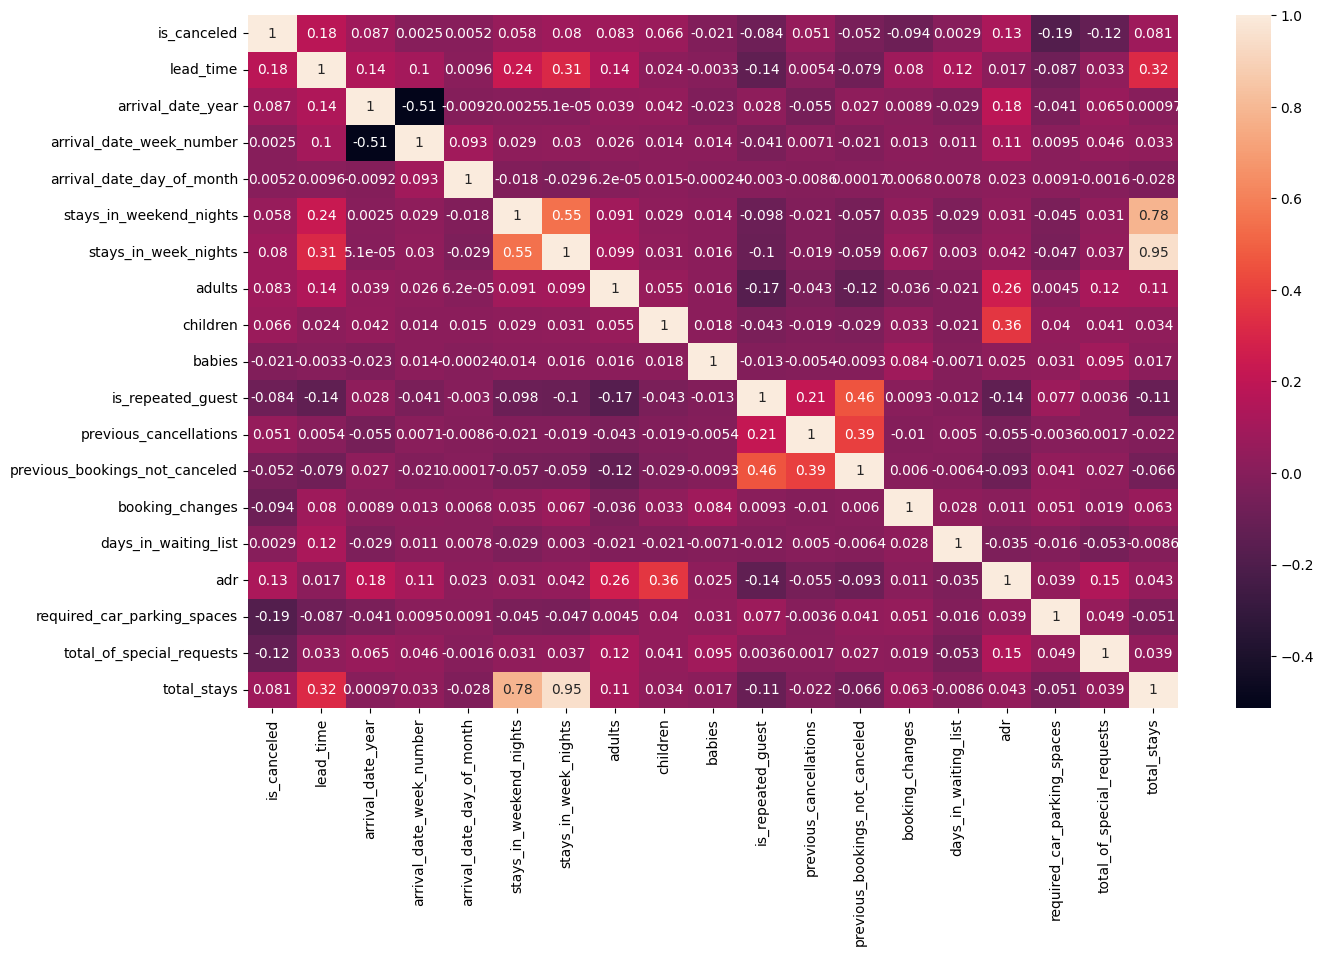

In [ ]:
corr_matrix=df_copy._get_numeric_data().corr()
plt.figure(figsize = (15,9))
sns.heatmap(corr_matrix, annot=True)
plt.show()

## is_canceled vs lead_time

In [ ]:
# number of instances for each value
df_copy["lead_time"].value_counts().sort_index()

0      5679
1      3141
2      1900
3      1690
4      1553
       ... 
608       2
615       2
622       2
626       1
629       2
Name: lead_time, Length: 476, dtype: int64

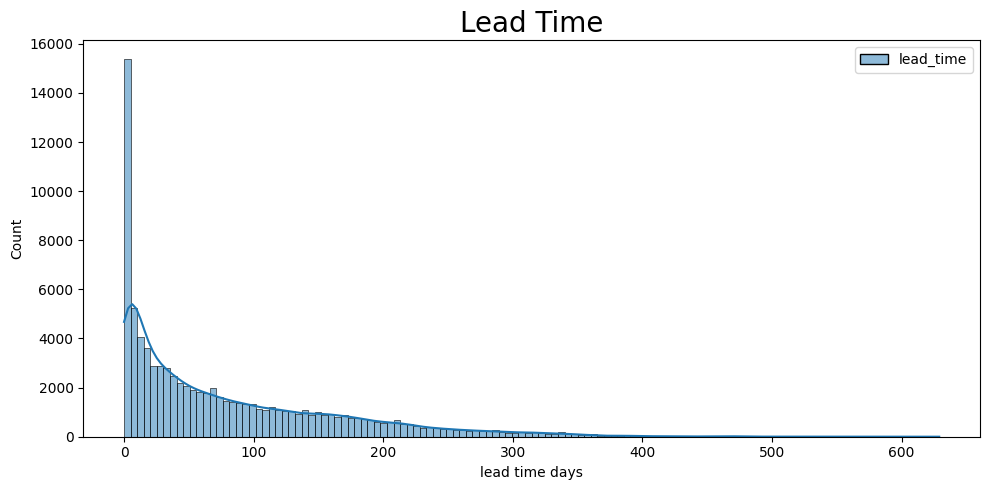

In [ ]:
plt.figure(figsize=(10,5))
lead_time = df_copy['lead_time']
lead_time = pd.DataFrame(sorted(lead_time, reverse = True), columns = ['lead_time'])
sns.histplot(lead_time, kde=True) # kde = kernel density estimation (displays distribution function, density curve)
plt.title("Lead Time", size=20)
plt.xlabel("lead time days")
plt.tight_layout()
plt.show()

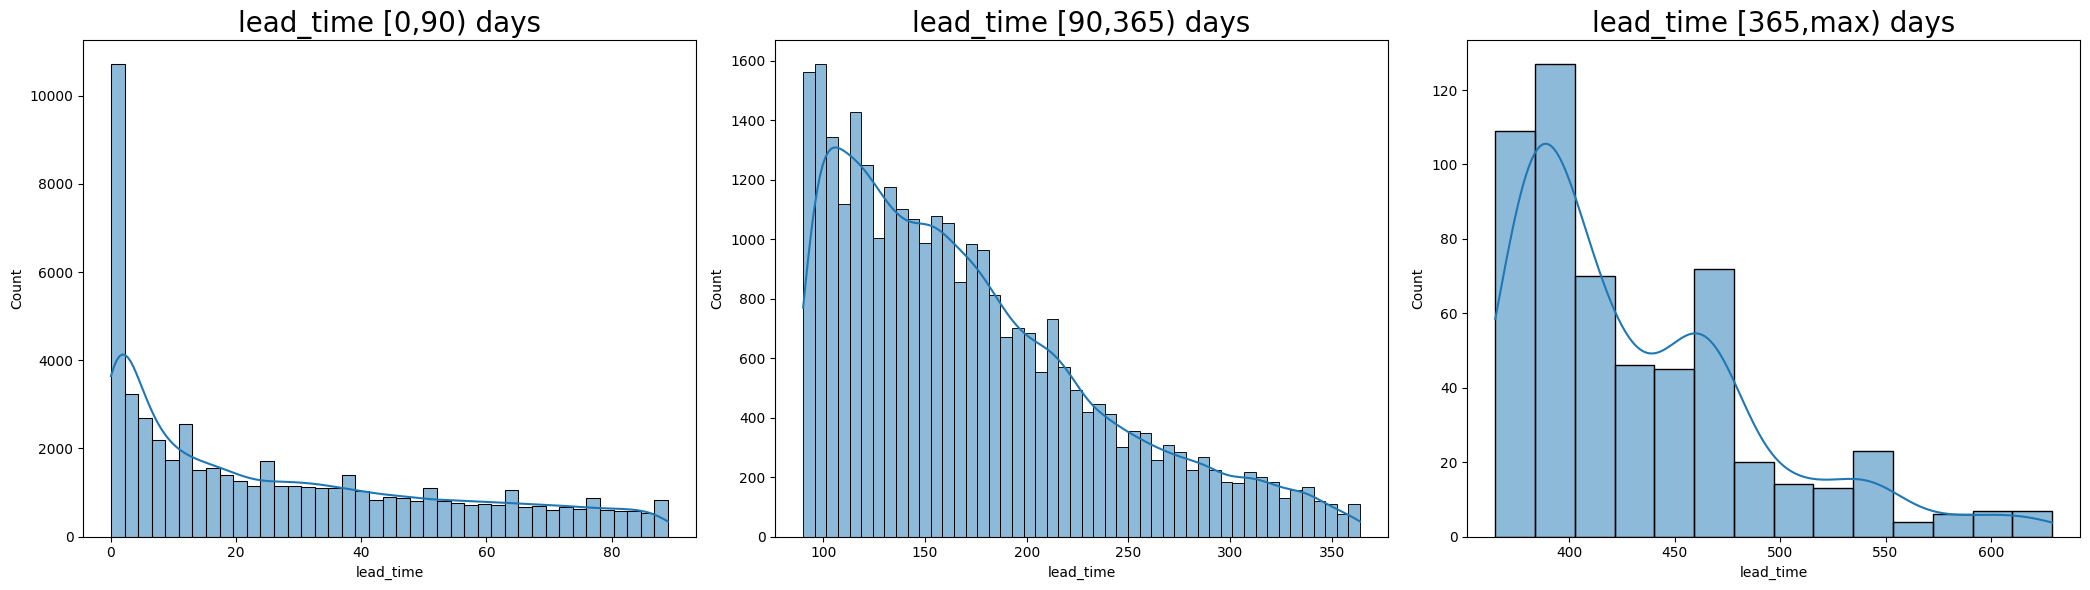

In [ ]:
# divides lead time by less than 90 days, 90-365 days and 365 or more days
lead_time_1 = df_copy[df_copy["lead_time"] < 90]
lead_time_2 = df_copy[(df_copy["lead_time"] >= 90) & (df_copy["lead_time"] < 365)]
lead_time_3 = df_copy[df_copy["lead_time"] >= 365]

# calculates cancellations according to lead time groups
lead_cancel_1 = lead_time_1["is_canceled"].value_counts()
lead_cancel_2 = lead_time_2["is_canceled"].value_counts()
lead_cancel_3 = lead_time_3["is_canceled"].value_counts()

# hist plot for each lead time group
fig, (bx1, bx2, bx3) = plt.subplots(1,3,figsize=(21,6))
sns.histplot(lead_time_1["lead_time"], ax=bx1, kde=True)
bx1.set_title("lead_time [0,90) days", size=20)
sns.histplot(lead_time_2["lead_time"], ax=bx2, kde=True)
bx2.set_title("lead_time [90,365) days", size=20)
sns.histplot(lead_time_3["lead_time"], ax=bx3, kde=True)
bx3.set_title("lead_time [365,max) days", size=20)
plt.tight_layout()
plt.show()

In [ ]:
# total count of lead time according to cancellation
total_lead_days_cancel = pd.DataFrame(data=[lead_cancel_1,lead_cancel_2,lead_cancel_3],
             index=["[0,90) days", "[90,365) days", "[365,max) days"])
total_lead_days_cancel

,0,1
"[0,90) days",43524,12836
"[90,365) days",18640,10834
"[365,max) days",336,227


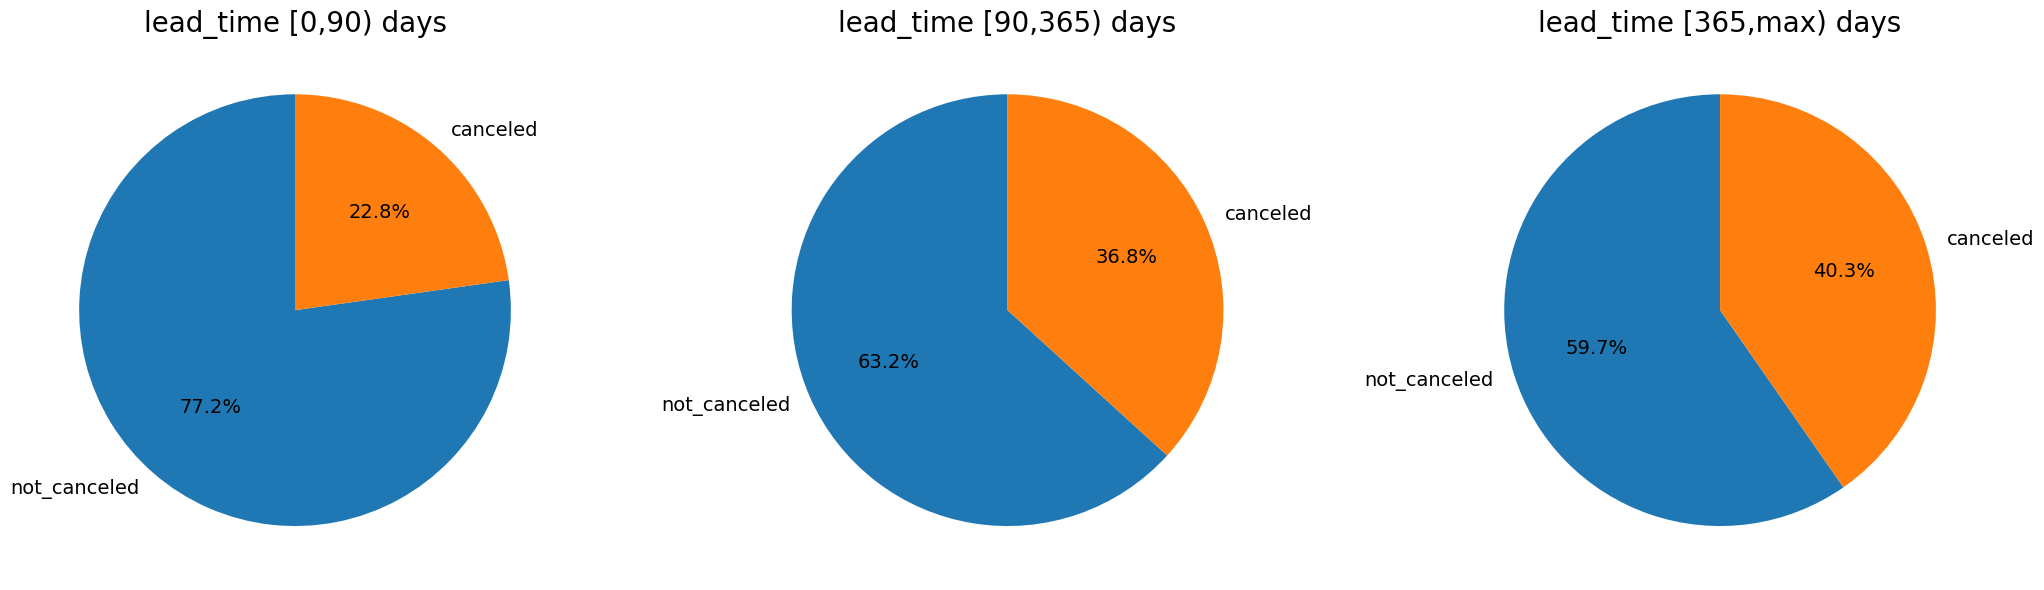

In [ ]:
# pie plot for each lead time group
fig, ax = plt.subplots(1,3, figsize=(21,6))
ax[0].pie(np.array([total_lead_days_cancel[0][0], total_lead_days_cancel[1][0]]),
          labels=["not_canceled", "canceled"], autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})
ax[0].set_title("lead_time [0,90) days", size=20)
ax[1].pie(np.array([total_lead_days_cancel[0][1], total_lead_days_cancel[1][1]]),
          labels=["not_canceled", "canceled"], autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})
ax[1].set_title("lead_time [90,365) days", size=20)
ax[2].pie(np.array([total_lead_days_cancel[0][2], total_lead_days_cancel[1][2]]),
          labels=["not_canceled", "canceled"], autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})
ax[2].set_title("lead_time [365,max) days", size=20)
plt.tight_layout()
plt.show()

## is_canceled vs adr

In [ ]:
# number of instances for each value
df_copy["adr"].value_counts().sort_index()

-6.38         1
 0.00      1046
 0.26         1
 0.50         1
 1.00        12
           ... 
 437.00       1
 450.00       1
 451.50       1
 508.00       1
 510.00       1
Name: adr, Length: 8858, dtype: int64

In [ ]:
df_copy = df_copy[(df_copy['adr'] >= 0) & (df_copy['adr'] <= 550)]

In [ ]:
df = df[(df['adr'] >= 0) & (df['adr'] <= 550)]

In [ ]:
df_copy["adr"].value_counts().sort_index()

0.00      1046
0.26         1
0.50         1
1.00        12
1.48         1
          ... 
437.00       1
450.00       1
451.50       1
508.00       1
510.00       1
Name: adr, Length: 8857, dtype: int64

In [ ]:
adr_intervals = [0, 50, 100, 150, 200, 250, 300, 550]

df_copy['adr_interval'] = pd.cut(df_copy['adr'], bins=adr_intervals)

total_bookings = df_copy.groupby('adr_interval').size().reset_index(name='total_bookings')
canceled_bookings = df_copy.groupby('adr_interval')['is_canceled'].sum().reset_index(name='canceled_bookings')

percentage = pd.merge(total_bookings, canceled_bookings, on='adr_interval')
percentage['cancellation_rate'] = (percentage['canceled_bookings'] / percentage['total_bookings'])*100
percentage

<ipython-input-52-679af2f28bd1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['adr_interval'] = pd.cut(df_copy['adr'], bins=adr_intervals)


,adr_interval,total_bookings,canceled_bookings,cancellation_rate
0,"(0, 50]",8036,1280,15.928323
1,"(50, 100]",35642,8703,24.417822
2,"(100, 150]",26564,8468,31.877729
3,"(150, 200]",10391,3530,33.971706
4,"(200, 250]",3499,1320,37.725064
5,"(250, 300]",958,367,38.308977
6,"(300, 550]",260,85,32.692308


## is_canceled vs total_stays

In [ ]:
# number of instances for each value
df_copy["total_stays"].value_counts().sort_index()

1     17139
2     15691
3     17763
4     13512
5      6704
6      3252
7      7511
8      1059
9       779
10     1071
11      366
12      196
13      131
14      859
15       69
16       33
17       20
18       24
19       22
20       14
21       55
22       12
23        5
24        6
25       14
26        6
27        4
28       33
29       13
30       13
33        2
34        1
35        5
38        1
42        4
45        1
46        1
48        1
56        2
60        1
69        1
Name: total_stays, dtype: int64

In [ ]:
df_copy = df_copy[(df_copy['total_stays'] <= 30)]

In [ ]:
df_copy["total_stays"].value_counts().sort_index()

1     17139
2     15691
3     17763
4     13512
5      6704
6      3252
7      7511
8      1059
9       779
10     1071
11      366
12      196
13      131
14      859
15       69
16       33
17       20
18       24
19       22
20       14
21       55
22       12
23        5
24        6
25       14
26        6
27        4
28       33
29       13
30       13
Name: total_stays, dtype: int64

In [ ]:
total_stays_intervals = [0, 3, 7, 10, 14, 20, 30]

df_copy['total_stays_interval'] = pd.cut(df_copy['total_stays'], bins=total_stays_intervals)

total_bookings = df_copy.groupby('total_stays_interval').size().reset_index(name='total_bookings')
canceled_bookings = df_copy.groupby('total_stays_interval')['is_canceled'].sum().reset_index(name='canceled_bookings')

percentage = pd.merge(total_bookings, canceled_bookings, on='total_stays_interval')
percentage['cancellation_rate'] = (percentage['canceled_bookings'] / percentage['total_bookings'])*100
percentage

<ipython-input-56-c19bdeb7bf62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['total_stays_interval'] = pd.cut(df_copy['total_stays'], bins=total_stays_intervals)


,total_stays_interval,total_bookings,canceled_bookings,cancellation_rate
0,"(0, 3]",50593,12666,25.035084
1,"(3, 7]",30979,9578,30.917718
2,"(7, 10]",2909,1007,34.616707
3,"(10, 14]",1552,456,29.381443
4,"(14, 20]",182,102,56.043956
5,"(20, 30]",161,84,52.173913


## is_canceled vs previous_cancellations

In [ ]:
# get previous cancellations column
prev_cancel = df_copy["previous_cancellations"]

In [ ]:
# sort the index values
prev_cancel.value_counts().sort_index()

0     84701
1      1399
2       110
3        61
4        30
5        19
6        17
11       27
13        4
14        1
19        1
21        1
24        2
25        2
26        1
Name: previous_cancellations, dtype: int64

In [ ]:
# create a list with previous cancellations indices
prev_cancel_index = df_copy["previous_cancellations"].value_counts().index.to_list()
prev_cancel_index.sort()

# calculate the average percentage of cancellations for each value in the DataFrame
percentage_prev_cancel= []
for i in prev_cancel_index:
    percentage_prev_cancel.append((round(df_copy[df_copy["previous_cancellations"]==i]["is_canceled"].mean()*100,2)))

In [ ]:
# create a DataFrame with the results
df_copy_prev_cancel = pd.DataFrame(percentage_prev_cancel, index=prev_cancel_index, columns=["Previous Cancellations %"])
df_copy_prev_cancel

,Previous Cancellations %
0,26.86
1,76.34
2,30.91
3,26.23
4,20.00
5,10.53
6,11.76
11,7.41
13,75.00
14,100.00


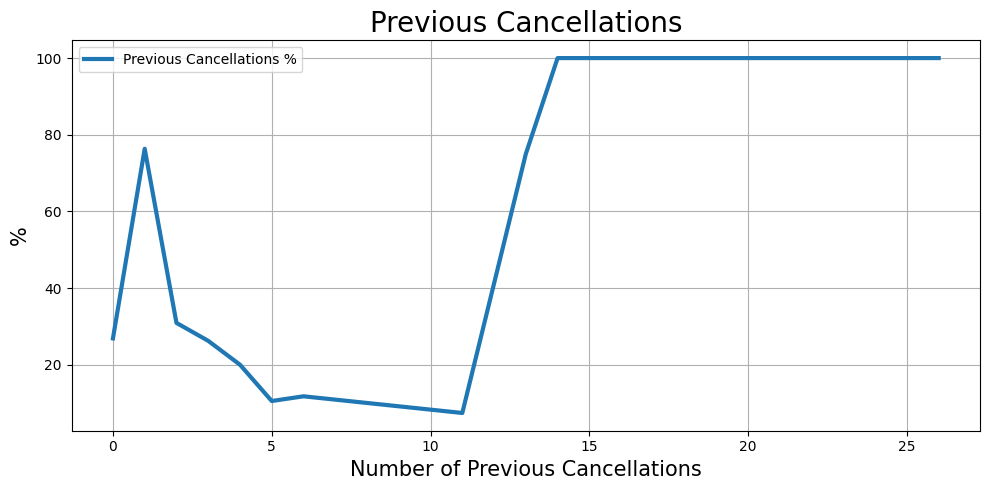

In [ ]:
df_copy_prev_cancel.plot(figsize= (10,5), linewidth=3)
plt.title("Previous Cancellations", size=20)
plt.xlabel("Number of Previous Cancellations", size=15)
plt.ylabel("%", size=15)
plt.tight_layout()
plt.grid(True)
plt.show()

## is_canceled vs is_repeated_guest




In [ ]:
# number of instances for each value
df_copy["is_repeated_guest"].value_counts().sort_index()

0    83234
1     3142
Name: is_repeated_guest, dtype: int64

In [ ]:
# group by cancellations
is_canceled = df_copy.groupby(by="is_canceled")

# get groups according to binary outcome
canceled = is_canceled.get_group(1)
not_canceled = is_canceled.get_group(0)

# count values for each outcome
is_repeated_guest_0 = not_canceled["is_repeated_guest"].value_counts()
is_repeated_guest_1 = canceled["is_repeated_guest"].value_counts()

# create a DataFrame for each outcome
df_copy_is_repeated_guest_0 = pd.DataFrame(is_repeated_guest_0.values, index=is_repeated_guest_0.index, columns=["not_canceled"])
df_copy_is_repeated_guest_1 = pd.DataFrame(is_repeated_guest_1.values, index=is_repeated_guest_1.index, columns=["canceled"])

# join both DataFrames side by side
df_copy_is_repeated_guest= df_copy_is_repeated_guest_0.join(df_copy_is_repeated_guest_1)

In [ ]:
# add total of both outcomes
is_repeated_guest_total = df_copy_is_repeated_guest["not_canceled"] + df_copy_is_repeated_guest["canceled"]

# calculate percentage of cancellations for each number of repeated guest value individually
is_repeated_guest_percentage = []
for i in is_repeated_guest_total.index:
    is_repeated_guest_percentage.append(round((is_repeated_guest_1[i]/is_repeated_guest_total[i])*100,2))

# add percentages as new column in DataFrame
df_copy_is_repeated_guest.join(pd.DataFrame(is_repeated_guest_percentage, index=df_copy_is_repeated_guest.index, columns=["cancellations %"]))

,not_canceled,canceled,cancellations %
0,59600,23634,28.39
1,2883,259,8.24


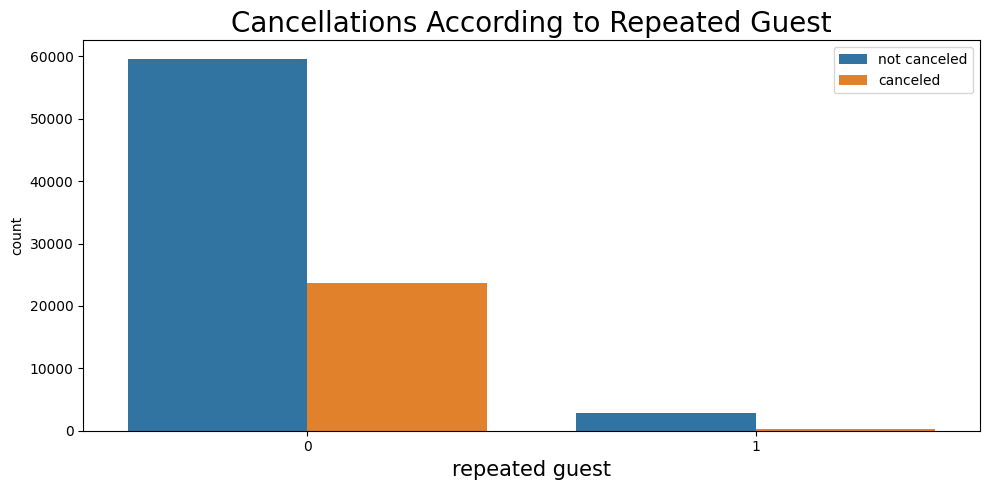

In [ ]:
# plot is_repeated_guest according to cancellations
plt.figure(figsize=(10,5))
sns.countplot(x=df_copy["is_repeated_guest"], hue=df_copy["is_canceled"])
plt.title("Cancellations According to Repeated Guest", size=20)
plt.xlabel("repeated guest", size=15)
plt.legend(["not canceled", "canceled"])
plt.tight_layout()
plt.show()

## is_canceled vs booking_changes

In [ ]:
# number of instances for each value
df_copy["booking_changes"].value_counts().sort_index()

0     70763
1     10732
2      3450
3       853
4       344
5       108
6        55
7        27
8        14
9         8
10        5
11        1
12        1
13        5
14        3
15        3
16        2
17        1
18        1
Name: booking_changes, dtype: int64

In [ ]:
# count values for each outcome with previous groupby
booking_changes_0 = not_canceled["booking_changes"].value_counts()
booking_changes_1 = canceled["booking_changes"].value_counts()

# count index of not canceled
len(booking_changes_0.index)

19

In [ ]:
# count index of canceled
len(booking_changes_1.index)

13

In [ ]:
df_copy_booking_changes_1 = pd.DataFrame(booking_changes_1, index=booking_changes_0.index)
df_copy_booking_changes_1.fillna({"booking_changes": 0}, inplace=True) # fill missing values, the outcome 0 has more values (filling the values will enable joining the dataframes later)
booking_changes_1 = pd.Series(df_copy_booking_changes_1["booking_changes"])

In [ ]:
# add total of both outcomes
booking_changes_total = booking_changes_0 + booking_changes_1

# calculate percentage of cancellations for each number of booking changes individually
percentage_booking_changes = []
for i in booking_changes_total.index:
    percentage_booking_changes.append(round((booking_changes_1[i]/booking_changes_total[i])*100,2))

In [ ]:
# create a DataFrame with the percentage of cancellations
df_copy_percentage_booking_changes = pd.DataFrame(percentage_booking_changes, index=booking_changes_total.index, columns=["cancellations %"])

# create a DataFrame for each outcome
df_copy_booking_changes_0 = pd.DataFrame(booking_changes_0.values, index=booking_changes_0.index, columns=["not_canceled"])
df_copy_booking_changes_1 = pd.DataFrame(booking_changes_1.values, index=booking_changes_1.index, columns=["canceled"])

In [ ]:
# join all three DataFrames side by side
df_copy_booking_changes = df_copy_booking_changes_0.join\
    ([df_copy_booking_changes_1, df_copy_percentage_booking_changes])

# remove rows with 0% cancellations
df_copy_booking_changes = df_copy_booking_changes[df_copy_booking_changes["cancellations %"]!=0]
df_copy_booking_changes

,not_canceled,canceled,cancellations %
0,49302,21461.0,30.33
1,9239,1493.0,13.91
2,2752,698.0,20.23
3,723,130.0,15.24
4,281,63.0,18.31
5,88,20.0,18.52
6,38,17.0,30.91
7,24,3.0,11.11
8,10,4.0,28.57
9,7,1.0,12.50


## is_canceled vs total_of_special_requests

In [ ]:
# number of instances for each value
df_copy["total_of_special_requests"].value_counts()

0    43338
1    28694
2    11700
3     2290
4      318
5       36
Name: total_of_special_requests, dtype: int64

In [ ]:
# group by cancellations
is_canceled = df_copy.groupby(by="is_canceled")

# get groups according to binary outcome
canceled = is_canceled.get_group(1)
not_canceled = is_canceled.get_group(0)

# count values for each outcome
special_requests_0 = not_canceled["total_of_special_requests"].value_counts()
special_requests_1 = canceled["total_of_special_requests"].value_counts()

# create a DataFrame for each outcome
df_copy_special_requests_0 = pd.DataFrame(special_requests_0.values, index=special_requests_0.index, columns=["not_canceled"])
df_copy_special_requests_1 = pd.DataFrame(special_requests_1.values, index=special_requests_1.index, columns=["canceled"])

# join both DataFrames side by side
df_copy_special_requests= df_copy_special_requests_0.join(df_copy_special_requests_1)

In [ ]:
# add total of both outcomes
special_requests_total = df_copy_special_requests["not_canceled"] + df_copy_special_requests["canceled"]

# calculate percentage of cancellations for each number of requests value individually
special_requests_percentage = []
for i in special_requests_total.index:
    special_requests_percentage.append(round((special_requests_1[i]/special_requests_total[i])*100,2))

# add percentages as new column in DataFrame
df_copy_special_requests.join(pd.DataFrame(special_requests_percentage, index=df_copy_special_requests.index, columns=["cancellations %"]))

,not_canceled,canceled,cancellations %
0,28833,14505,33.47
1,22233,6461,22.52
2,9201,2499,21.36
3,1898,392,17.12
4,284,34,10.69
5,34,2,5.56


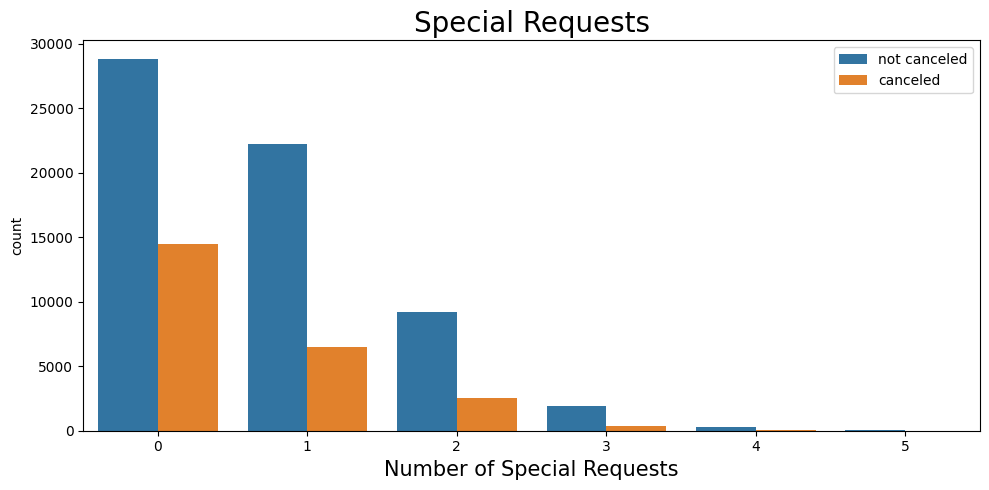

In [ ]:
# plot special requests according to cancellations
plt.figure(figsize=(10,5))
sns.countplot(x=df_copy["total_of_special_requests"], hue=df_copy["is_canceled"])
plt.title("Special Requests", size=20)
plt.xlabel("Number of Special Requests", size=15)
plt.legend(["not canceled", "canceled"])
plt.tight_layout()
plt.show()

## is_canceled vs hotel

In [ ]:
df_copy["hotel"].value_counts()

City Hotel      52799
Resort Hotel    33577
Name: hotel, dtype: int64

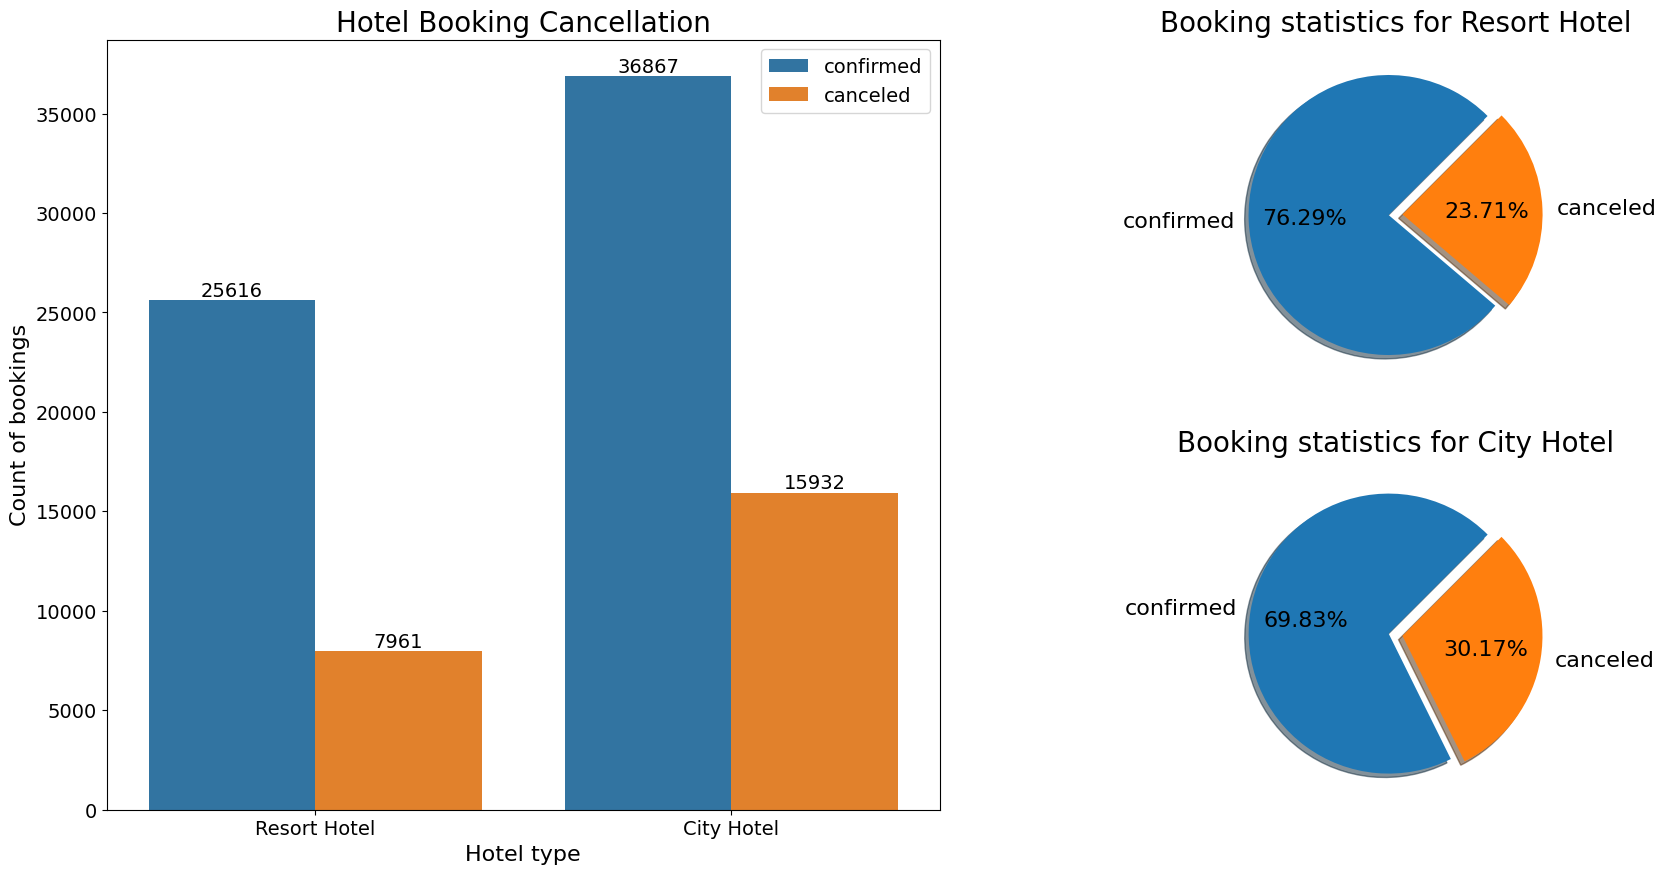

In [ ]:
fig = plt.figure(figsize=(22, 10))
grid = plt.GridSpec(2, 4, hspace=0.2, wspace=0.1)
ax1 = fig.add_subplot(grid[0:, :2])
ax2 = fig.add_subplot(grid[0, 2:])
ax3 = fig.add_subplot(grid[1, 2:])

# countplot to show booking cancelation in each type of hotel
sns.countplot(x="hotel", data=df_copy, hue="is_canceled", ax=ax1).set_title('Hotel Booking Cancellation', fontsize=20)
ax1.set_xlabel('Hotel type', fontsize=16)
ax1.set_ylabel('Count of bookings', fontsize=16)
ax1.tick_params(axis='both', labelsize=14)
ax1.bar_label(ax1.containers[0], fontsize=14)
ax1.bar_label(ax1.containers[1], fontsize=14)
ax1.legend(labels=['confirmed', 'canceled'], loc=0, fontsize=14)

# pieplot to show booking statistics for Resort Hotel and City Hotel
resort_data = df_copy[df_copy["hotel"]=="Resort Hotel"]['is_canceled'].value_counts(normalize=True)
city_data = df_copy[df_copy["hotel"]=="City Hotel"]['is_canceled'].value_counts(normalize=True)
titles = ['Resort Hotel', 'City Hotel']
data = [resort_data, city_data]
labels = ['confirmed', 'canceled']
explode = [0.05, 0.05]
for i, ax in enumerate([ax2, ax3]):
    ax.pie(data[i], labels=labels, explode=explode, autopct='%0.2f%%', startangle=45, textprops={'fontsize': 16}, shadow=True)
    ax.set_title(f'Booking statistics for {titles[i]}', fontsize=20)

In [ ]:
resort_canceled_percent = []
city_canceled_percent = []

# divide cancellation outcome by hotel and month of arrival
resort_1 = canceled[canceled["hotel"]=="Resort Hotel"]["arrival_date_month"].value_counts()
resort_0 = not_canceled[not_canceled["hotel"]=="Resort Hotel"]["arrival_date_month"].value_counts()
city_1 = canceled[canceled["hotel"]=="City Hotel"]["arrival_date_month"].value_counts()
city_0 = not_canceled[not_canceled["hotel"]=="City Hotel"]["arrival_date_month"].value_counts()

# calculate cancellation percentage according to hotel
for i in month:
    resort_canceled_percent.append(round((resort_1[i] / (resort_0[i]+resort_1[i]))*100,2))
    city_canceled_percent.append(round((city_1[i]/(city_0[i]+city_1[i]))*100,2))

# create a DataFrame with the cancellation percentage of each hotel
df_copy_resort_cancel = pd.DataFrame(resort_canceled_percent, index=month, columns=["Resort Hotel Canceled %"])
df_copy_city_cancel = pd.DataFrame(city_canceled_percent, index=month, columns=["City Hotel Canceled %"])

# join DataFrames
df_copy_hotel_cancel = df_copy_resort_cancel.join(df_copy_city_cancel)
df_copy_hotel_cancel

,Resort Hotel Canceled %,City Hotel Canceled %
January,14.09,28.16
February,17.75,27.14
March,17.67,28.20
April,23.37,34.48
May,23.91,32.40
June,30.42,30.47
July,30.40,33.22
August,32.66,32.13
September,23.56,25.15
October,19.15,27.07


## is_canceled vs deposit_type

In [ ]:
df_copy["deposit_type"].value_counts()

No Deposit    85237
Non Refund     1032
Refundable      107
Name: deposit_type, dtype: int64

In [ ]:
# calculate deposit type instances percentage in data
deposit_percent = round(df_copy["deposit_type"].value_counts()/len(df_copy["deposit_type"])*100,4)
deposit_percent

No Deposit    98.6813
Non Refund     1.1948
Refundable     0.1239
Name: deposit_type, dtype: float64

In [ ]:
# use groupby to divide according to deposit type
deposit = df_copy.groupby(by="deposit_type")
non_refund = deposit.get_group("Non Refund")
refundable = deposit.get_group("Refundable")
no_deposit = deposit.get_group("No Deposit")

# calculate number of cancellations according to deposit type
no_deposit_0 = (no_deposit["is_canceled"]==0).sum()
no_deposit_1 = (no_deposit["is_canceled"]==1).sum()
non_refund_0 = (non_refund["is_canceled"]==0).sum()
non_refund_1 = (non_refund["is_canceled"]==1).sum()
refundable_0 = (refundable["is_canceled"]==0).sum()
refundable_1 = (refundable["is_canceled"]==1).sum()
all_canceled = no_deposit_1 + non_refund_1 + refundable_1
all_not_canceled = no_deposit_0 + non_refund_0 + refundable_0

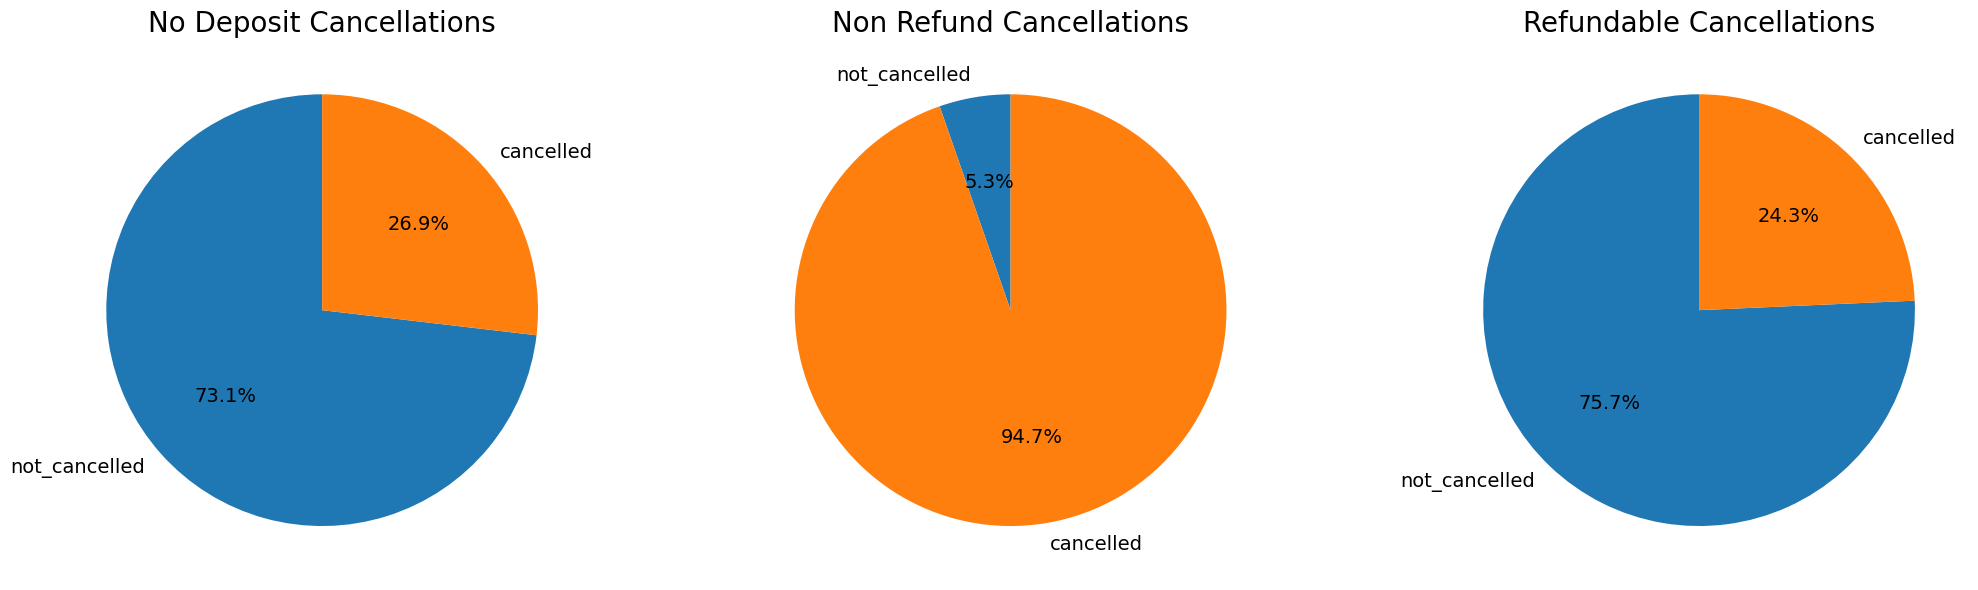

In [ ]:
# pie plot of cancellations according to deposit type
cancel_labels = ["not_cancelled", "cancelled"]
fig, dx = plt.subplots(1,3, figsize=(21,6))
dx[0].pie(np.array([no_deposit_0, no_deposit_1]), labels=cancel_labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})
dx[0].set_title("No Deposit Cancellations", size=20)
dx[1].pie(np.array([non_refund_0, non_refund_1]), labels=cancel_labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})
dx[1].set_title("Non Refund Cancellations", size=20)
dx[2].pie(np.array([refundable_0, refundable_1]), labels=cancel_labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})
dx[2].set_title("Refundable Cancellations", size=20)
plt.tight_layout()
plt.show()

# Cancellation Prediction

In [ ]:
#corr_matrix = df.corr()
#corr_matrix['is_canceled'].sort_values(ascending=False)

In [ ]:
df['is_canceled'].corr(df['stays_in_weekend_nights'])

0.05795745104808908

In [ ]:
df['is_canceled'].corr(df['stays_in_week_nights'])

0.08014068299734015

In [ ]:
df['is_canceled'].corr(df['total_stays'])

0.08137976355547433

In [ ]:
df.shape

(86396, 31)

In [ ]:
#df.info()

In [ ]:
#num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
#                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
#                "babies","is_repeated_guest", "previous_cancellations",
#                "previous_bookings_not_canceled","agent","company",
#                "required_car_parking_spaces", "total_of_special_requests", "adr"]
#
#cat_features = ["hotel","arrival_date_month","meal","market_segment",
#               "distribution_channel","reserved_room_type","deposit_type","customer_type"]

In [ ]:
df.drop(['stays_in_weekend_nights', 'stays_in_week_nights'], axis=1, inplace=True) # we use total_stays

In [ ]:
df.drop(['arrival_date_day_of_month', 'arrival_date_year', 'days_in_waiting_list', 'booking_changes',
         'assigned_room_type', 'country', 'reservation_status', 'reservation_status_date'], axis=1, inplace=True)

In [ ]:
cat_list = []
for i in df.select_dtypes(object).columns:
    print (i, df[i].nunique())
    cat_list.append(i)

hotel 2
arrival_date_month 12
meal 4
market_segment 8
distribution_channel 5
reserved_room_type 9
deposit_type 3
customer_type 4


In [ ]:
enc=LabelEncoder()

for i in cat_list:
    df[i] = enc.fit_transform(df[i])

In [ ]:
#df.head()

In [ ]:
X = df.drop('is_canceled', axis=1).values
y = df['is_canceled'].values

In [ ]:
#X

In [ ]:
# splitting data into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=True)

In [ ]:
# splitting data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [ ]:
X_train.shape

(51837, 20)

In [ ]:
X_val.shape

(21599, 20)

In [ ]:
X_test.shape

(12960, 20)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Model Building

## Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy Score of Logistic Regression is : {acc_lr}")

Accuracy Score of Logistic Regression is : 0.7692129629629629


In [ ]:
clf_report = classification_report(y_test, y_pred_lr)
print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0       0.78      0.95      0.86      9390
           1       0.70      0.29      0.41      3570

    accuracy                           0.77     12960
   macro avg       0.74      0.62      0.63     12960
weighted avg       0.76      0.77      0.73     12960



## KNN

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_val)

acc_knn = accuracy_score(y_val, y_pred_knn)
print(f"Accuracy Score of KNN is : {acc_knn}")

Accuracy Score of KNN is : 0.772767257743414


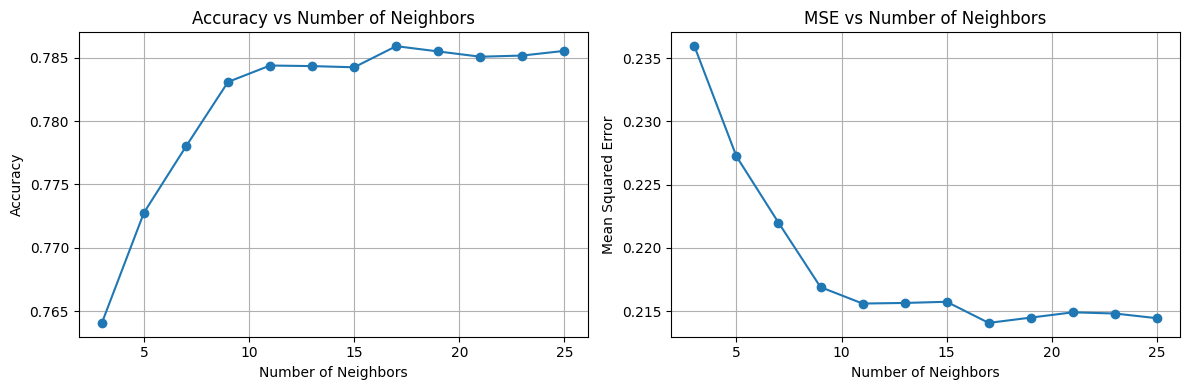

In [ ]:
neighbors = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
accuracies = []
val_mse = []

for nb in neighbors:
    knn = KNeighborsClassifier(n_neighbors=nb)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_val)
    iter_val_mse = mean_squared_error(y_val, y_pred_knn)
    val_mse.append(iter_val_mse)
    acc_knn = accuracy_score(y_val, y_pred_knn)
    accuracies.append(acc_knn)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(neighbors, accuracies, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Neighbors')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(neighbors, val_mse, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Number of Neighbors')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy Score of KNN is : {acc_knn}")

Accuracy Score of KNN is : 0.787962962962963


In [ ]:
clf_report = classification_report(y_test, y_pred_knn)
print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      9390
           1       0.66      0.47      0.55      3570

    accuracy                           0.79     12960
   macro avg       0.74      0.69      0.71     12960
weighted avg       0.78      0.79      0.78     12960



## Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_val)

acc_dtc = accuracy_score(y_val, y_pred_dtc)
print(f"Accuracy Score of Decision Tree is : {acc_dtc}")

Accuracy Score of Decision Tree is : 0.7440159266632714


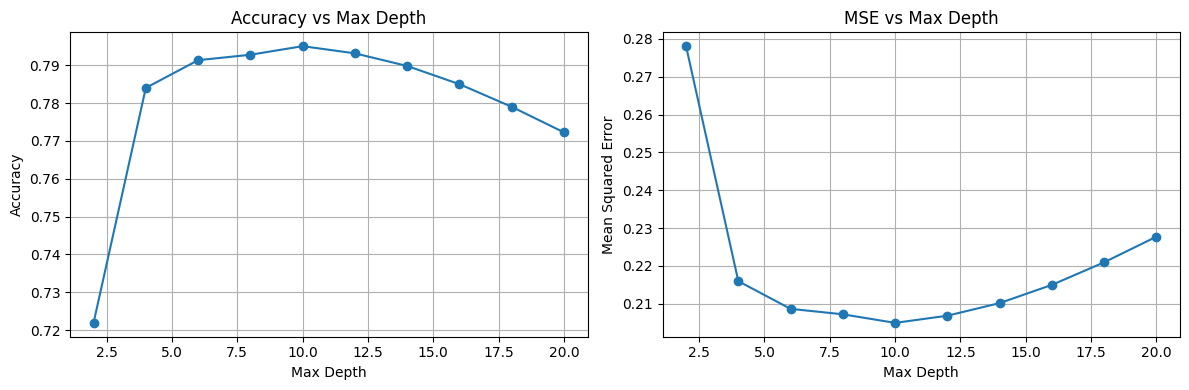

In [ ]:
max_depth = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
accuracies = []
val_mse = []

for i in max_depth:
    dtc = DecisionTreeClassifier(max_depth=i)
    dtc.fit(X_train, y_train)
    y_pred_dtc = dtc.predict(X_val)
    iter_val_mse = mean_squared_error(y_val, y_pred_dtc)
    val_mse.append(iter_val_mse)
    acc_dtc = accuracy_score(y_val, y_pred_dtc)
    accuracies.append(acc_dtc)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(max_depth, accuracies, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(max_depth, val_mse, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Max Depth')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(y_test, y_pred_dtc)
print(f"Accuracy Score of Decision Tree is : {acc_dtc}")

Accuracy Score of Decision Tree is : 0.797608024691358


In [ ]:
clf_report = classification_report(y_test, y_pred_dtc)
print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      9390
           1       0.69      0.48      0.57      3570

    accuracy                           0.80     12960
   macro avg       0.76      0.70      0.72     12960
weighted avg       0.79      0.80      0.79     12960



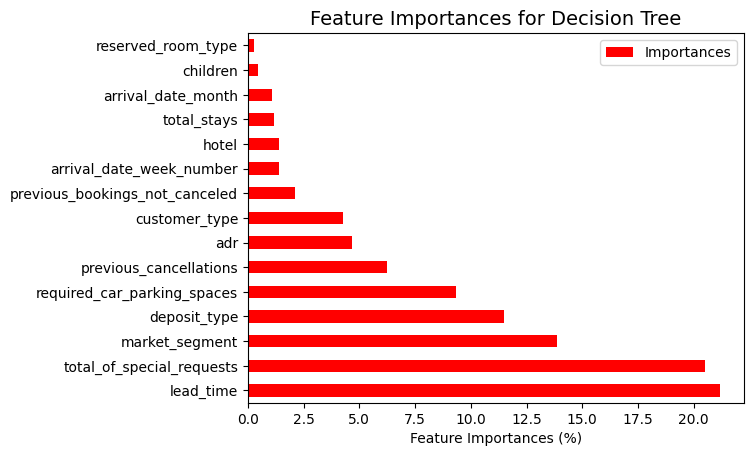

In [ ]:
pd.DataFrame(data = dtc.feature_importances_*100,
                   columns = ["Importances"],
                   index = df.drop('is_canceled', axis = 1).columns).sort_values("Importances", ascending = False)[:15].plot(kind = "barh", color = "r")

plt.xlabel("Feature Importances (%)")
plt.title("Feature Importances for Decision Tree", size=14)
plt.show()

## Random Forest Classifier

In [ ]:
rd_clf = RandomForestClassifier()
rd_clf.fit(X_train, y_train)
y_pred_rd_clf = rd_clf.predict(X_val)

acc_rd_clf = accuracy_score(y_val, y_pred_rd_clf)
print(f"Accuracy Score of Random Forest is : {acc_rd_clf}")

Accuracy Score of Random Forest is : 0.8020741701004677


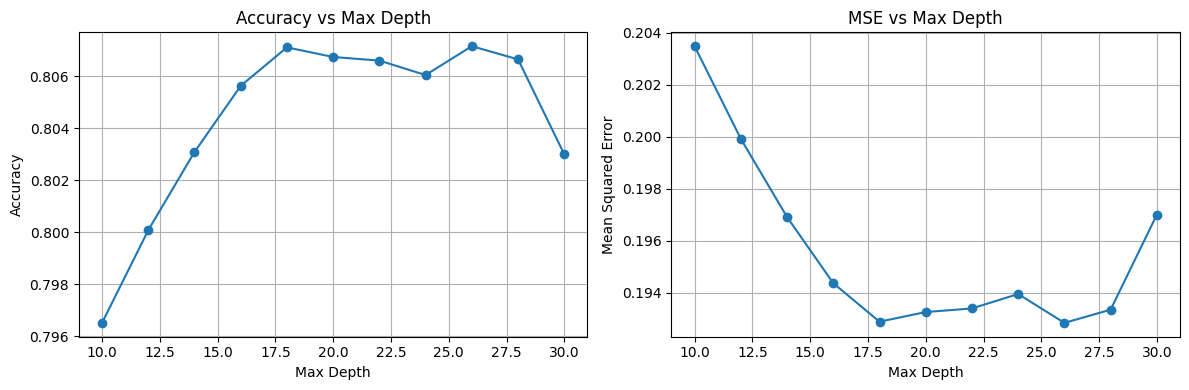

In [ ]:
max_depth = [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
accuracies = []
val_mse = []

for i in max_depth:
    rd_clf = RandomForestClassifier(max_depth=i)
    rd_clf.fit(X_train, y_train)
    y_pred_rd_clf = rd_clf.predict(X_val)
    iter_val_mse = mean_squared_error(y_val, y_pred_rd_clf)
    val_mse.append(iter_val_mse)
    acc_rd_clf = accuracy_score(y_val, y_pred_rd_clf)
    accuracies.append(acc_rd_clf)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(max_depth, accuracies, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(max_depth, val_mse, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Max Depth')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
rd_clf = RandomForestClassifier(max_depth=20)
rd_clf.fit(X_train, y_train)
y_pred_rd_clf = rd_clf.predict(X_test)

acc_rd_clf = accuracy_score(y_test, y_pred_rd_clf)
print(f"Accuracy Score of Random Forest is : {acc_rd_clf}")

Accuracy Score of Random Forest is : 0.811033950617284


In [ ]:
clf_report = classification_report(y_test, y_pred_rd_clf)
print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0       0.83      0.92      0.88      9390
           1       0.72      0.51      0.60      3570

    accuracy                           0.81     12960
   macro avg       0.78      0.72      0.74     12960
weighted avg       0.80      0.81      0.80     12960



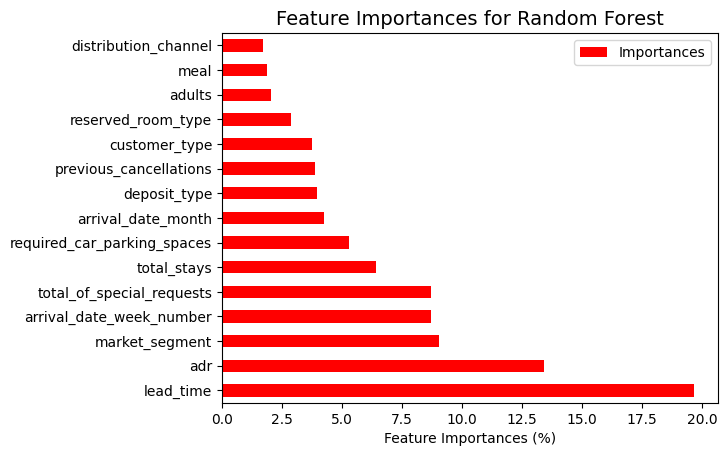

In [ ]:
pd.DataFrame(data = rd_clf.feature_importances_*100,
                   columns = ["Importances"],
                   index = df.drop('is_canceled', axis = 1).columns).sort_values("Importances", ascending = False)[:15].plot(kind = "barh", color = "r")

plt.xlabel("Feature Importances (%)")
plt.title("Feature Importances for Random Forest", size=14)
plt.show()

## Models Comparison

In [ ]:
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Decision Tree Classifier', 'Random Forest Classifier'],
    'Score' : [acc_lr, acc_knn, acc_dtc, acc_rd_clf]})

models.sort_values(by = 'Score', ascending = False)

,Model,Score
3,Random Forest Classifier,0.810340
2,Decision Tree Classifier,0.797608
1,KNN,0.787963
0,Logistic Regression,0.769213


In [ ]:
px.bar(data_frame = models, x = 'Score', y = 'Model', color = 'Score', template = 'plotly_dark', title = 'Models Comparison')

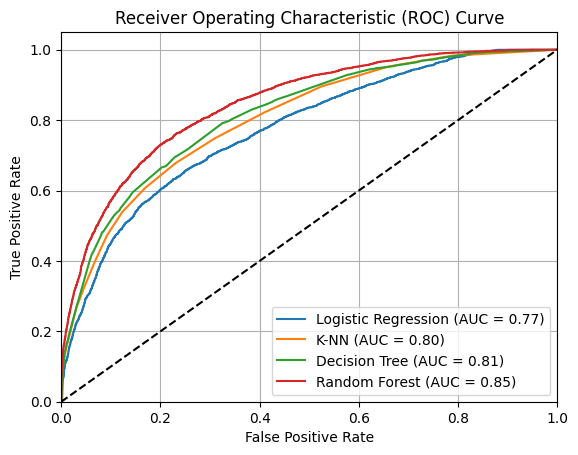

In [ ]:
logreg = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=17)
dtc = DecisionTreeClassifier(max_depth=10)
rd_clf = RandomForestClassifier(max_depth=20)

logreg.fit(X_train, y_train)
knn.fit(X_train, y_train)
dtc.fit(X_train, y_train)
rd_clf.fit(X_train, y_train)

# predict probabilities for each model
logreg_probs = logreg.predict_proba(X_test)[:, 1]
knn_probs = knn.predict_proba(X_test)[:, 1]
dtc_probs = dtc.predict_proba(X_test)[:, 1]
rdclf_probs = rd_clf.predict_proba(X_test)[:, 1]

# compute ROC curve and AUC for each model
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_probs)
logreg_auc = roc_auc_score(y_test, logreg_probs)

knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
knn_auc = roc_auc_score(y_test, knn_probs)

dtc_fpr, dtc_tpr, _ = roc_curve(y_test, dtc_probs)
dtc_auc = roc_auc_score(y_test, dtc_probs)

rdclf_fpr, rdclf_tpr, _ = roc_curve(y_test, rdclf_probs)
rdclf_auc = roc_auc_score(y_test, rdclf_probs)

# plot the ROC curves
plt.plot(logreg_fpr, logreg_tpr, label='Logistic Regression (AUC = {:.2f})'.format(logreg_auc))
plt.plot(knn_fpr, knn_tpr, label='K-NN (AUC = {:.2f})'.format(knn_auc))
plt.plot(dtc_fpr, dtc_tpr, label='Decision Tree (AUC = {:.2f})'.format(dtc_auc))
plt.plot(rdclf_fpr, rdclf_tpr, label='Random Forest (AUC = {:.2f})'.format(rdclf_auc))

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

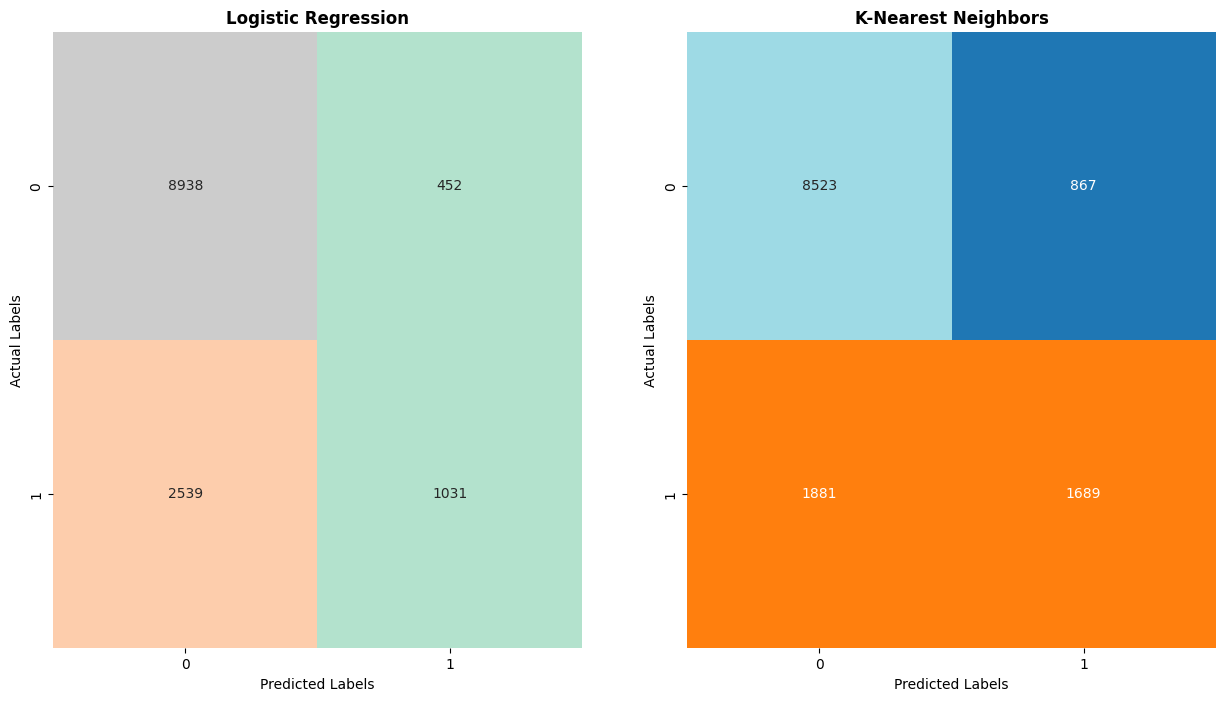

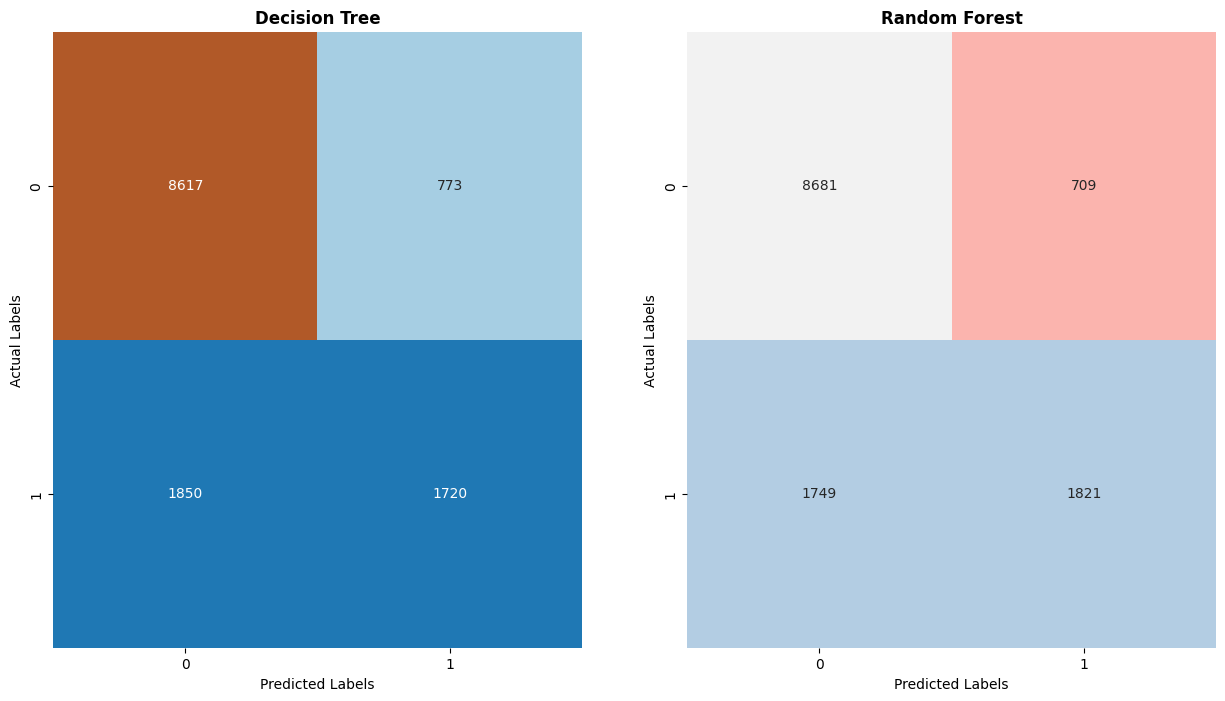

In [ ]:
# confusion matrix
LR_matrix = confusion_matrix(y_test, y_pred_lr)
KNN_matrix = confusion_matrix(y_test, y_pred_knn)
DTC_matrix = confusion_matrix(y_test, y_pred_dtc)
RF_matrix = confusion_matrix(y_test, y_pred_rd_clf)

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(LR_matrix, annot=True, fmt="d", cbar=False, cmap="Pastel2", ax=ax[0]).set_ylim([2, 0])
ax[0].set_title("Logistic Regression", weight='bold')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('Actual Labels')

sns.heatmap(KNN_matrix, annot=True, fmt="d", cbar=False, cmap="tab20", ax=ax[1]).set_ylim([2, 0])
ax[1].set_title("K-Nearest Neighbors", weight='bold')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('Actual Labels')

fig, axe = plt.subplots(1, 2, figsize=(15, 8))
sns.heatmap(DTC_matrix, annot=True, fmt="d", cbar=False, cmap="Paired", ax=axe[0]).set_ylim([2, 0])
axe[0].set_title("Decision Tree", weight='bold')
axe[0].set_xlabel('Predicted Labels')
axe[0].set_ylabel('Actual Labels')

sns.heatmap(RF_matrix, annot=True, fmt="d", cbar=False, cmap="Pastel1", ax=axe[1]).set_ylim([2, 0])
axe[1].set_title("Random Forest", weight='bold')
axe[1].set_xlabel('Predicted Labels')
axe[1].set_ylabel('Actual Labels')
plt.show()